# Notebook containing four experiments for Individual NLP COM3029 Coursework
This notebook contains the code cells for the four experiments I conducted for the individual component of the COM3029 coursework. \
The four experiments conducted in this notebook are: \
1.  Comparing BERT and RoBERTA models in pre-trained, fine tuned and full-trained form.
2. Different data pre-processing techniques on the dataset
3. Hyper parameter optimization
4. RNN vs LSTM


# Pre-requisite: Installing dependencies

In [ ]:
%pip install datasets
%pip install transformers
%pip install spacy
%pip install spacy-transformers
%pip install transformers[torch]
%pip install seqeval


%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install tqdm
!python -m spacy download en_core_web_sm


In [ ]:
# !pip install wandb
from datasets import load_metric, load_dataset
from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel, BertTokenizer 
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import numpy as np
import transformers
from transformers import EarlyStoppingCallback
from tqdm.notebook import tqdm
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Helper functions (for all experiments)
You must run this cell before running any experiments


In [ ]:
evaluation_label_list = ["B-O", "B-AC", "B-LF", "I-LF"]

def conv_label_indexes(training, valid, test ):
	label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

	label_list = []
	for sample in training:
		label_list.append([label_encoding[tag] for tag in sample])

	val_label_list = []
	for sample in valid:
		val_label_list.append([label_encoding[tag] for tag in sample])

	test_label_list = []
	for sample in test:
		test_label_list.append([label_encoding[tag] for tag in sample])
	return label_list, val_label_list, test_label_list

def tokenize_and_align_labels(dataset, tokenizer, label_list):
    tokenized_inputs = tokenizer(dataset, truncation=True, is_split_into_words=True) ## For some models, you may need to set max_length to approximately 500.

    labels = []
    for i, label in enumerate(label_list):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# BERT's tokenizer returns the dataset in the form of a dictionary of lists (sentences).
# we have to convert it into a list of dictionaries for training.
def turn_dict_to_list_of_dict(d):
    new_list = []

    for labels, inputs in zip(d["labels"], d["input_ids"]):
        entry = {"input_ids": inputs, "labels": labels}
        new_list.append(entry)

    return new_list


import numpy as np

metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [evaluation_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [evaluation_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


# Prepare the test data for evaluation in the same format as the training data
def calculate_results(trainer, data):
	predictions, labels, _ = trainer.predict(data)
	predictions = np.argmax(predictions, axis=2)

	# Remove the predictions for the [CLS] and [SEP] tokens
	true_predictions = [
			[evaluation_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
			for prediction, label in zip(predictions, labels)
	]
	true_labels = [
			[evaluation_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
			for prediction, label in zip(predictions, labels)
	]

	# Compute multiple metrics on the test restuls
	results = metric.compute(predictions=true_predictions, references=true_labels)
	return results, true_labels, true_predictions


def plot_cm(y_true, y_pred, figsize=(10,10)):
  y_true = [item for sublist in y_true for item in sublist]
  y_pred = [item for sublist in y_pred for item in sublist]
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
      for j in range(ncols):
          c = cm[i, j]
          p = cm_perc[i, j]
          if i == j:
              s = cm_sum[i]
              annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
          elif c == 0:
              annot[i, j] = ''
          else:
              annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  plt.savefig('output.png')
  sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax).figure.savefig('file.png')





# Experiment 1: Comparing BERT to ROBERTA model in both pre-trained and fine-tuned form



In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

## Defining ground truth label list / options


In [ ]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.2.1+cu121
torchtext Version:  0.17.1+cpu
Using GPU.


## Loading Dataset

In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

## Defining various helper functions

## Load BERT model
The first stage of this experiment is to view the performance of the BERT model in its pre-trained form

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=4)

###Pre-process data (like in other experiments)


In [ ]:
training = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

training_tokens = training["tokens"]
valid_tokens = valid["tokens"]
test_tokens = test["tokens"]

training_labels = training["ner_tags"]
valid_labels = valid["ner_tags"]
test_labels = test["ner_tags"]

In [ ]:
#convert label lists to indexes
label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)


tokenized_train = tokenize_and_align_labels(training_tokens, bert_tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(valid_tokens, bert_tokenizer, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_tokens, bert_tokenizer, test_label_list)

tokenized_train = turn_dict_to_list_of_dict(tokenized_train)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(bert_tokenizer)


In [ ]:
print(len(label_list))
print(len(valid_labels))

1072
126


### Pre-Trained BERT performance (no fine tuning)

In [ ]:

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    bert_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
results, mylabels, mypreds = calculate_results(trainer, tokenized_test)
results

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'AC': {'precision': 0.09341368919500646,
  'recall': 0.396709323583181,
  'f1': 0.15121951219512197,
  'number': 547},
 'LF': {'precision': 0.018369175627240143,
  'recall': 0.1357615894039735,
  'f1': 0.03235990528808209,
  'number': 302},
 'O': {'precision': 0.8756046993780235,
  'recall': 0.23476005188067445,
  'f1': 0.37025131502045583,
  'number': 5397},
 'overall_precision': 0.25408197267577476,
 'overall_recall': 0.24415626000640409,
 'overall_f1': 0.24902024820378837,
 'overall_accuracy': 0.25063900165388664}

#### Plot conf matrix for pre-trained BERT

<ipython-input-11-5153b249d042>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


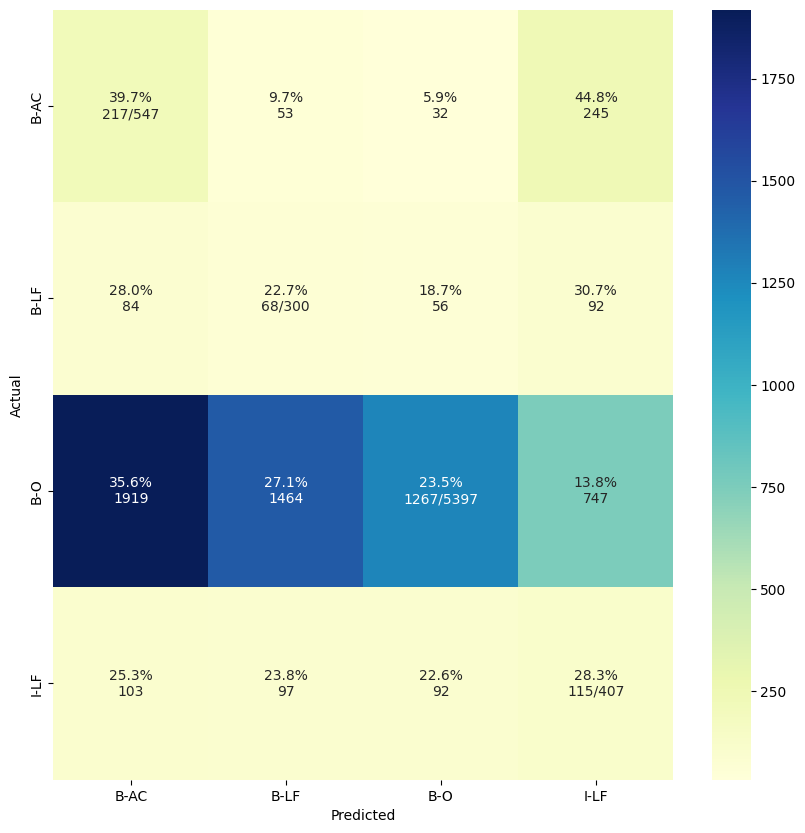

In [ ]:
##plot confusion matrix using
plot_cm(mylabels, mypreds)

#### Results of pre-trained BERT
From the above f1 score of 0.03  and overall accuracy of 25%, we can see that pre-trained BERT without fine tuning does not perform well for our token classification task

### Fine tune BERT and run test set against it
To fine-tune BERT, we train it with our training data set

In [ ]:
trainer.train()


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.16453654048454702, metrics={'train_runtime': 166.2906, 'train_samples_per_second': 38.679, 'train_steps_per_second': 9.67, 'total_flos': 278780100881088.0, 'train_loss': 0.16453654048454702, 'epoch': 6.0})

In [ ]:
results, mylabels, mypreds = calculate_results(trainer, tokenized_test)
results


{'AC': {'precision': 0.7521815008726004,
  'recall': 0.7879341864716636,
  'f1': 0.7696428571428572,
  'number': 547},
 'LF': {'precision': 0.7087087087087087,
  'recall': 0.7814569536423841,
  'f1': 0.7433070866141733,
  'number': 302},
 'O': {'precision': 0.9662225558266091,
  'recall': 0.9540485454882343,
  'f1': 0.9600969606563491,
  'number': 5397},
 'overall_precision': 0.9327987169206094,
 'overall_recall': 0.9311559398014729,
 'overall_f1': 0.9319766044387469,
 'overall_accuracy': 0.9276800481130657}

<ipython-input-11-5153b249d042>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


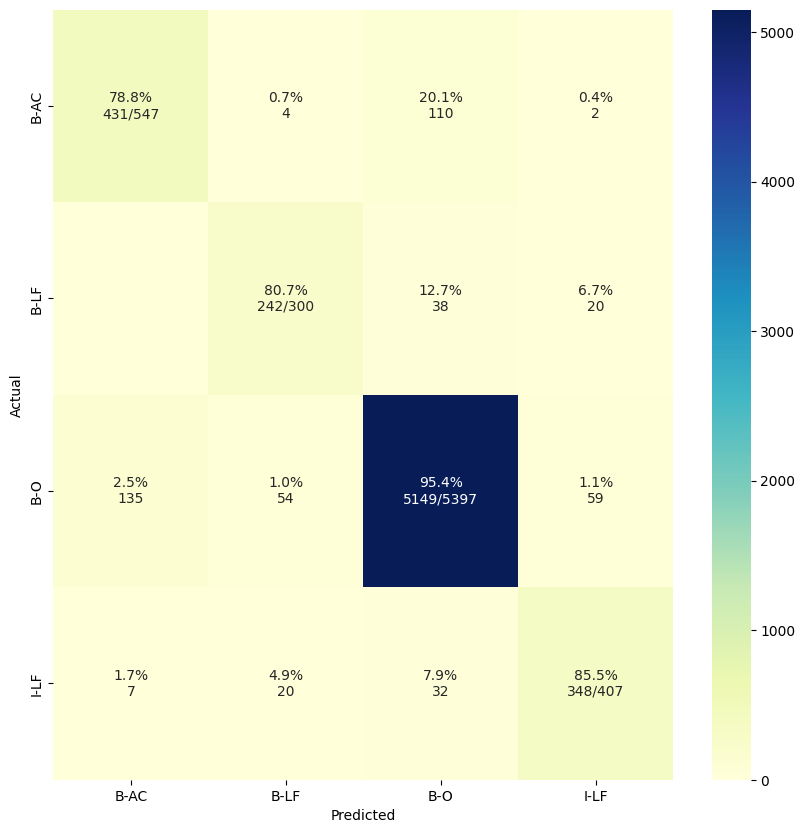

In [ ]:
plot_cm(mylabels, mypreds)

#### Results of fine-tuned BERT

blah blah blah

### Full-training BERT
Full training involves initializing the model with random weights, and then training the model with our dataset


In [ ]:
training = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

training_tokens = training["tokens"]
valid_tokens = valid["tokens"]
test_tokens = test["tokens"]

training_labels = training["ner_tags"]
valid_labels = valid["ner_tags"]
test_labels = test["ner_tags"]

In [ ]:
from transformers import AutoTokenizer, BertConfig, AutoModelForTokenClassification

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

bert_config = BertConfig.from_pretrained("bert-base-uncased", num_labels=4)

bert_model = AutoModelForTokenClassification.from_config(bert_config)


In [ ]:
#convert label lists to indexes
label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)


tokenized_train = tokenize_and_align_labels(training_tokens, bert_tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(valid_tokens, bert_tokenizer, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_tokens, bert_tokenizer, test_label_list)

tokenized_train = turn_dict_to_list_of_dict(tokenized_train)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(bert_tokenizer)


In [ ]:

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    bert_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.5536482962802868, metrics={'train_runtime': 164.5848, 'train_samples_per_second': 39.08, 'train_steps_per_second': 9.77, 'total_flos': 278075811731808.0, 'train_loss': 0.5536482962802868, 'epoch': 6.0})

In [ ]:
results, mylabels, mypreds = calculate_results(trainer, tokenized_test)
results


{'AC': {'precision': 0.49409780775716694,
  'recall': 0.5356489945155393,
  'f1': 0.5140350877192982,
  'number': 547},
 'LF': {'precision': 0.10109289617486339,
  'recall': 0.12251655629139073,
  'f1': 0.11077844311377245,
  'number': 302},
 'O': {'precision': 0.8794186255158801,
  'recall': 0.9080970909764684,
  'f1': 0.8935278030993619,
  'number': 5397},
 'overall_precision': 0.8008266993263932,
 'overall_recall': 0.8374959974383606,
 'overall_f1': 0.8187509782438567,
 'overall_accuracy': 0.8040896105848745}

<ipython-input-11-5153b249d042>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


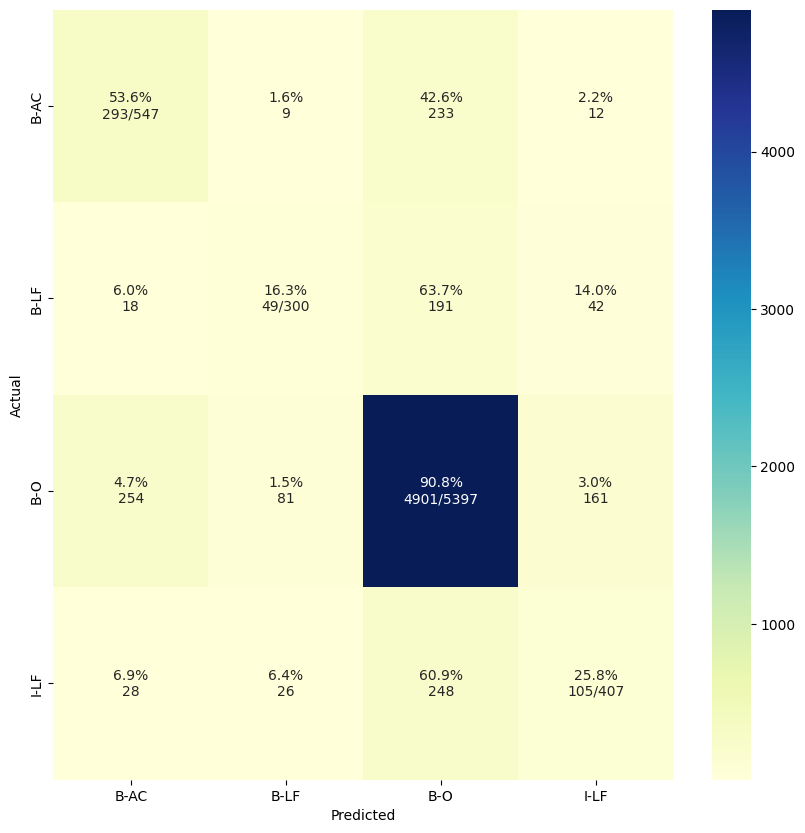

In [ ]:
plot_cm(mylabels, mypreds)

## Evaluating RoBERTa

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

pretrained_rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)




In [ ]:
#tokenize training set
label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)
tokenized_train = tokenize_and_align_labels(training_tokens, rob_tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(valid_tokens, rob_tokenizer,  val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_tokens, rob_tokenizer, test_label_list)

tokenized_train = turn_dict_to_list_of_dict(tokenized_train)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(rob_tokenizer)

### Pre trained ROBERTA performance

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

model_name = "roberta-base"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"ROBERTA-finedtuned-ner",
    evaluation_strategy ='steps',
    eval_steps = 100,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    pretrained_rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
pretrain_results, mylabels, mypreds = calculate_results(trainer, tokenized_test)
pretrain_results


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'AC': {'precision': 0.04174573055028463,
  'recall': 0.03935599284436494,
  'f1': 0.04051565377532228,
  'number': 559},
 'LF': {'precision': 0.022079589216944803,
  'recall': 0.296551724137931,
  'f1': 0.04109916367980884,
  'number': 290},
 'O': {'precision': 0.9073426573426573,
  'recall': 0.19681456200227532,
  'f1': 0.3234652539732003,
  'number': 5274},
 'overall_precision': 0.20589292130794107,
 'overall_recall': 0.18716315531602157,
 'overall_f1': 0.19608178629480708,
 'overall_accuracy': 0.20875576036866358}

<ipython-input-11-5153b249d042>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


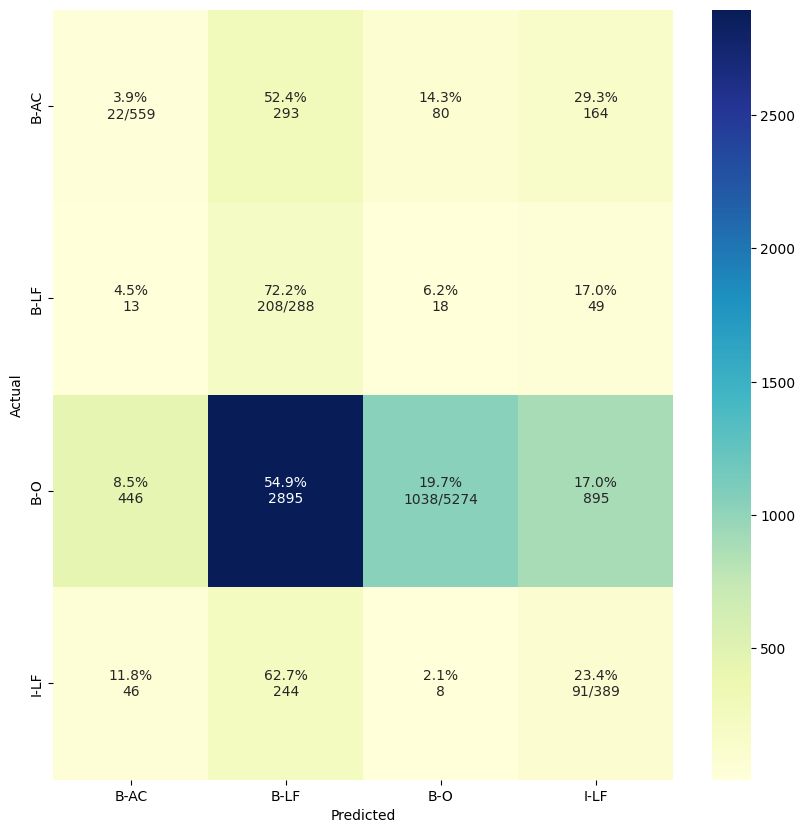

In [ ]:
plot_cm(mylabels,mypreds)

### Fine tune ROBERTA with training and look at result

In [ ]:
trainer.train()


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.225476,0.920210,0.921928,0.921068,0.915172
200,No log,0.204101,0.932472,0.930414,0.931442,0.927447
300,No log,0.182922,0.942268,0.930754,0.936475,0.932169
400,No log,0.178735,0.950317,0.941446,0.945861,0.939723
500,0.287500,0.199194,0.942222,0.935506,0.938852,0.933270
600,0.287500,0.213914,0.944207,0.936354,0.940264,0.932326
700,0.287500,0.191610,0.954201,0.940597,0.947350,0.940353
800,0.287500,0.193662,0.947152,0.939919,0.943522,0.935946
900,0.287500,0.263323,0.939891,0.934148,0.937011,0.930123
1000,0.140700,0.206738,0.952625,0.945350,0.948974,0.941926


TrainOutput(global_step=1608, training_loss=0.1654114340668294, metrics={'train_runtime': 190.9943, 'train_samples_per_second': 33.676, 'train_steps_per_second': 8.419, 'total_flos': 270367418028384.0, 'train_loss': 0.1654114340668294, 'epoch': 6.0})

In [ ]:
results, mylabels, mypreds = calculate_results(trainer, tokenized_test)
results

{'AC': {'precision': 0.849290780141844,
  'recall': 0.8568872987477638,
  'f1': 0.8530721282279609,
  'number': 559},
 'LF': {'precision': 0.735202492211838,
  'recall': 0.8137931034482758,
  'f1': 0.7725040916530278,
  'number': 290},
 'O': {'precision': 0.9747591522157996,
  'recall': 0.9592339780053091,
  'f1': 0.966934250764526,
  'number': 5274},
 'overall_precision': 0.9504526748971194,
 'overall_recall': 0.9430017965049812,
 'overall_f1': 0.9467125758321036,
 'overall_accuracy': 0.941321044546851}

<ipython-input-11-5153b249d042>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


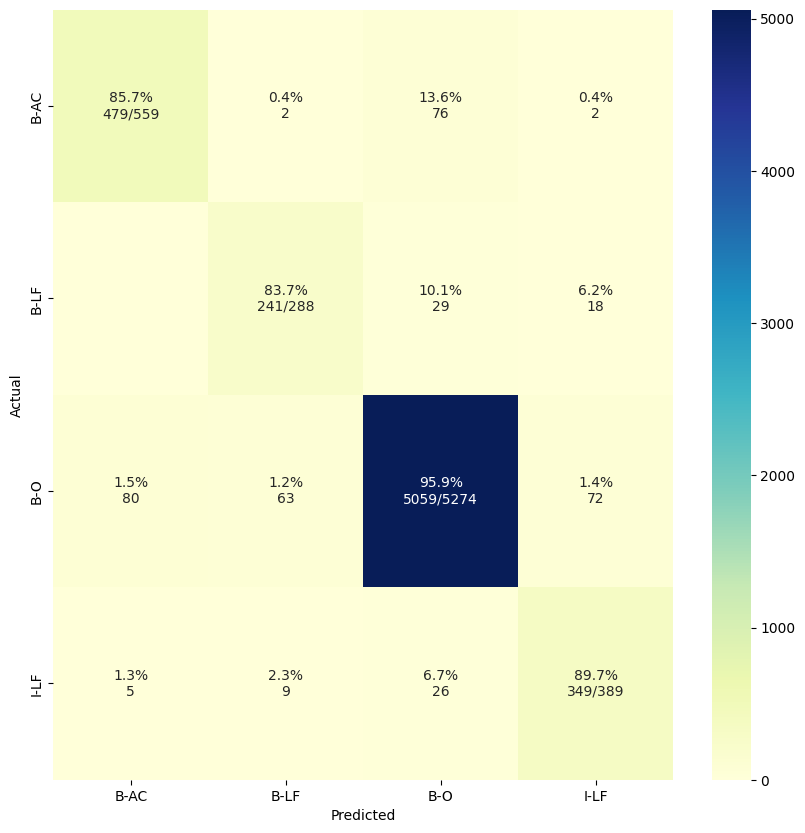

In [ ]:
plot_cm(mylabels,mypreds)

### Results of fine-tuned ROBERTA Model
Performance of fine tuned roberta is very similar to that of the fine-tuned BERT model.


*   BERT (fine tuned) F1 score: 0.71, total accuracy 0.93
*   ROBERTA (fine tuned) F1 score: 0.76, total accuracy 0.94
The difference is negligible, but Roberta is more computationally expensive to train / fine tune.
It is worth noting that ROBERTA pre-trained out performs pre-trained BERT with an f1 score of


*   BERT (pre-trained): 'overall_f1': 0.030502730182639805,
 'overall_accuracy': 0.25063900165388664}
*   ROBERTA (pre-trained) 'overall_f1': 0.02394948835183976,
 'overall_accuracy': 0.3278033794162826}





### Full-training ROBERTA
Full training involves initializing the model with random weights, and then training the model with our dataset


In [ ]:
from transformers import AutoTokenizer, BertConfig, AutoModelForTokenClassification

rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space = True)

rob_config = BertConfig.from_pretrained("roberta-base", num_labels=4)

rob_model  = AutoModelForTokenClassification.from_config(rob_config)


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


In [ ]:
#tokenize training set
label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)
tokenized_train = tokenize_and_align_labels(training_tokens, rob_tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(valid_tokens, rob_tokenizer,  val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_tokens, rob_tokenizer, test_label_list)

tokenized_train = turn_dict_to_list_of_dict(tokenized_train)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(rob_tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

model_name = "roberta-base"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"ROBERTA-finedtuned-ner",
    evaluation_strategy ='steps',
    eval_steps = 100,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)



/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.635945,0.795873,0.857604,0.825586,0.797608
200,No log,0.596573,0.803276,0.865580,0.833265,0.805162
300,No log,0.604738,0.805930,0.862695,0.833347,0.806893
400,No log,0.551132,0.817389,0.874406,0.844936,0.821530
500,0.674300,0.543586,0.808332,0.866090,0.836215,0.814605
600,0.674300,0.558274,0.796675,0.845893,0.820547,0.805162
700,0.674300,0.533134,0.818644,0.874915,0.845845,0.824205
800,0.674300,0.522067,0.821729,0.879328,0.849553,0.826251
900,0.674300,0.540207,0.803792,0.848948,0.825753,0.812244
1000,0.504600,0.520584,0.818066,0.869993,0.843231,0.825307


TrainOutput(global_step=1608, training_loss=0.5262326506239858, metrics={'train_runtime': 197.4462, 'train_samples_per_second': 32.576, 'train_steps_per_second': 8.144, 'total_flos': 270589932571200.0, 'train_loss': 0.5262326506239858, 'epoch': 6.0})

In [ ]:
results, mylabels, mypreds = calculate_results(trainer, tokenized_test)
results

{'AC': {'precision': 0.5504132231404959,
  'recall': 0.5957066189624329,
  'f1': 0.5721649484536083,
  'number': 559},
 'LF': {'precision': 0.09660574412532637,
  'recall': 0.12758620689655173,
  'f1': 0.1099554234769688,
  'number': 290},
 'O': {'precision': 0.8828428650749583,
  'recall': 0.9044368600682594,
  'f1': 0.8935094127563923,
  'number': 5274},
 'overall_precision': 0.8042559849788765,
 'overall_recall': 0.8394577821329414,
 'overall_f1': 0.8214799424644398,
 'overall_accuracy': 0.8081413210445468}

<ipython-input-11-5153b249d042>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


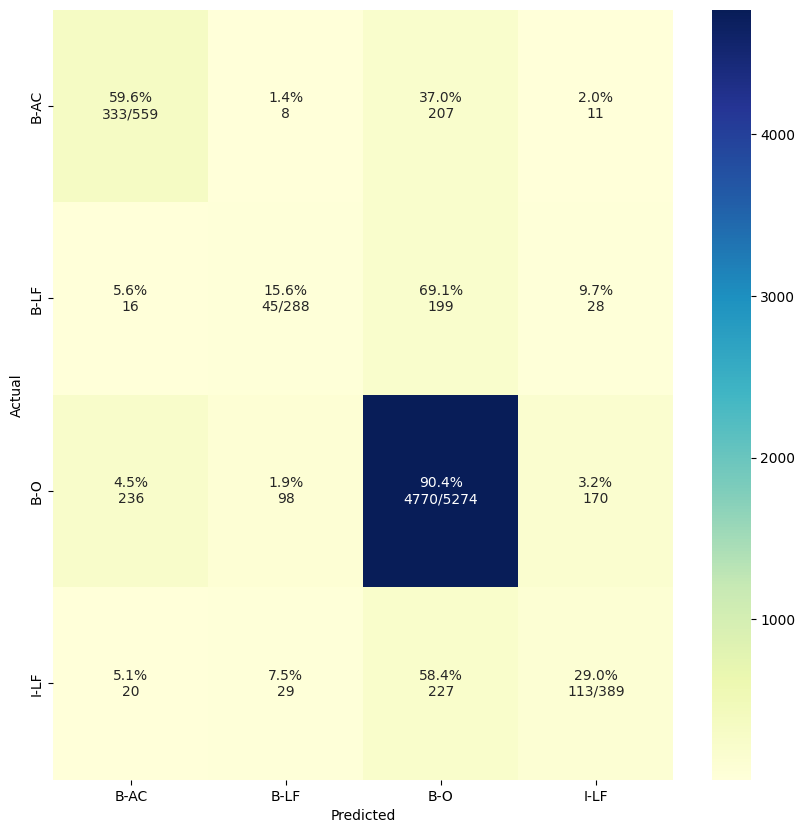

In [ ]:
plot_cm(mylabels,mypreds)

# Experiment 2: Data Pre-Processing techniques


In [ ]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.2.1+cu121
torchtext Version:  0.17.1+cpu
Using GPU.


In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

## N-Grams

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=4)

In [ ]:
training = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

training_tokens = training["tokens"]
training_labels = training["ner_tags"]
valid_tokens = valid["tokens"]
valid_labels = valid["ner_tags"]
test_tokens = test["tokens"]
test_labels = test["ner_tags"]



In [ ]:
evaluation_label_list = ["B-O", "B-AC", "B-LF", "I-LF"]

In [ ]:
def n_grams(tokens, labels, n):
  all_ngrams = []
  all_labels = []
  for i in range(0,len(tokens)):
    for j in range(len(tokens[i]) - n +1):
      all_ngrams.append(tokens[i][j:j+n])
      all_labels.append(labels[i][j:j+n])
  return all_ngrams, all_labels



In [ ]:

label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)


training_ngrams, training_ner = n_grams(training_tokens, label_list, 4)
valid_ngrams, valid_ner = n_grams(valid_tokens, val_label_list, 4)
test_ngrams, test_ner = n_grams(test_tokens, test_label_list, 4)

tokenized_datasets = tokenize_and_align_labels(training_ngrams, tokenizer, training_ner)
tokenized_val_datasets = tokenize_and_align_labels(valid_ngrams,tokenizer,  valid_ner)
tokenized_test_datasets = tokenize_and_align_labels(test_ngrams,tokenizer, test_ner)

tokenized_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

In [ ]:
training_ngrams[0]

['For', 'this', 'purpose', 'the']

In [ ]:
training_ner[0]

[0, 0, 0, 0]

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

model_name = "bert-base-uncased"
epochs = 6
batch_size = 32
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=6900, training_loss=0.129056513413139, metrics={'train_runtime': 795.2171, 'train_samples_per_second': 277.577, 'train_steps_per_second': 8.677, 'total_flos': 1506753654197352.0, 'train_loss': 0.129056513413139, 'epoch': 6.0})

In [ ]:
n_gram_results, true_labels, true_preds = calculate_results(trainer, tokenized_test)
n_gram_results

{'AC': {'precision': 0.7100538599640933,
  'recall': 0.7890274314214464,
  'f1': 0.7474604299551146,
  'number': 2005},
 'LF': {'precision': 0.5126582278481012,
  'recall': 0.5325054784514244,
  'f1': 0.522393407380867,
  'number': 1369},
 'O': {'precision': 0.9303944315545244,
  'recall': 0.9185075842410669,
  'f1': 0.9244127968033606,
  'number': 19646},
 'overall_precision': 0.8833152527663267,
 'overall_recall': 0.8842745438748914,
 'overall_f1': 0.8837946380115055,
 'overall_accuracy': 0.8708376209096522}

<ipython-input-33-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


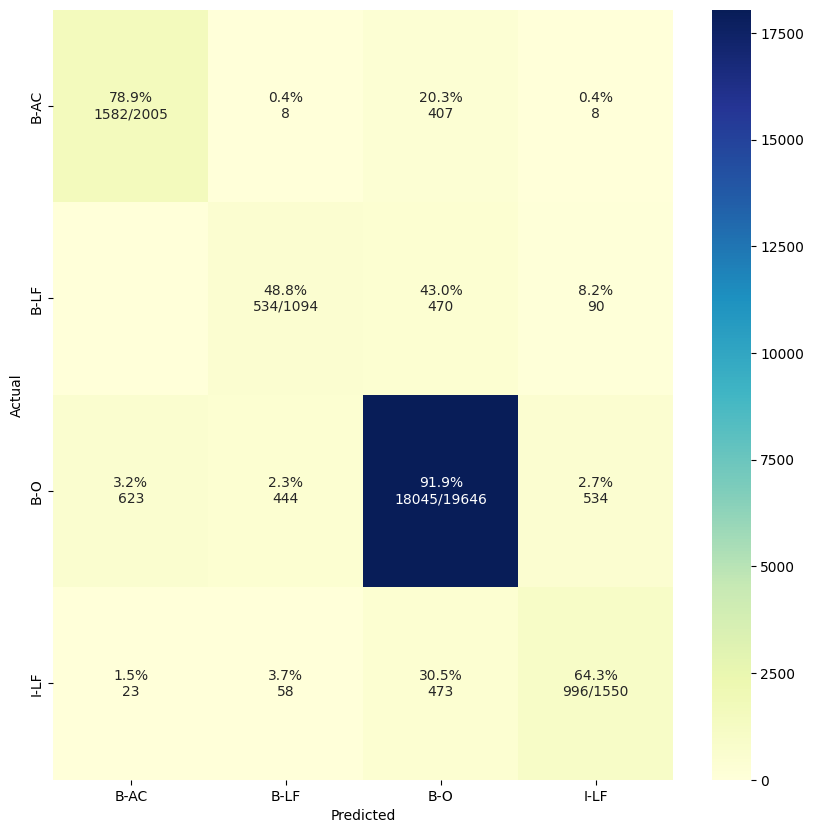

In [ ]:
plot_cm(true_labels, true_preds)


### Analysis of n-grams for BERT

## Removing stopwords
The 2nd approach I am going to take is to remove stopwords from the dataset (both tokens and their associated labels)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
training = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

training_tokens = training["tokens"]
training_labels = training["ner_tags"]
valid_tokens = valid["tokens"]
valid_labels = valid["ner_tags"]
test_tokens = test["tokens"]
test_labels = test["ner_tags"]



In [ ]:
import nltk
from nltk.corpus import stopwords

def remove_stopwords(tokens, labels):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = []
    filtered_labels = []

    for sublist_tokens, sublist_labels in zip(tokens, labels):
        filtered_tokens_sublist = []
        filtered_labels_sublist = []

        for token, label in zip(sublist_tokens, sublist_labels):
            if token.lower() not in stop_words:
                filtered_tokens_sublist.append(token)
                filtered_labels_sublist.append(label)

        filtered_tokens.append(filtered_tokens_sublist)
        filtered_labels.append(filtered_labels_sublist)

    return filtered_tokens, filtered_labels


In [ ]:
filtered_train_tokens, filtered_train_labels = remove_stopwords(training_tokens, training_labels)
filtered_valid_tokens, filtered_valid_labels = remove_stopwords(valid_tokens, valid_labels)
filtered_test_tokens, filtered_test_labels = remove_stopwords(test_tokens, test_labels)


In [ ]:

label_list, val_label_list, test_label_list = conv_label_indexes(filtered_train_labels, filtered_valid_labels, filtered_test_labels)

tokenized_datasets = tokenize_and_align_labels(filtered_train_tokens, tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(filtered_valid_tokens, tokenizer, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(filtered_test_tokens, tokenizer, test_label_list)

tokenized_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)



### Fine tune the model with these tokens and labels, then evaluate against the test set

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model2 = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args2 = TrainingArguments(
    f"BERT-finetuned-NER",
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer2 = Trainer(
    model2,
    args2,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer2.train()


Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.20144078713744434, metrics={'train_runtime': 155.5117, 'train_samples_per_second': 41.36, 'train_steps_per_second': 10.34, 'total_flos': 241438486044480.0, 'train_loss': 0.20144078713744434, 'epoch': 6.0})

In [ ]:
results, true_labels, true_preds = calculate_results(trainer2, tokenized_test)
results

{'AC': {'precision': 0.7542662116040956,
  'recall': 0.8170055452865065,
  'f1': 0.7843833185448092,
  'number': 541},
 'LF': {'precision': 0.685459940652819,
  'recall': 0.7649006622516556,
  'f1': 0.7230046948356808,
  'number': 302},
 'O': {'precision': 0.960545193687231,
  'recall': 0.9409697821503865,
  'f1': 0.9506567270145545,
  'number': 4269},
 'overall_precision': 0.9187071498530852,
 'overall_recall': 0.9174491392801252,
 'overall_f1': 0.9180777136145639,
 'overall_accuracy': 0.9141506002182612}

<ipython-input-33-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


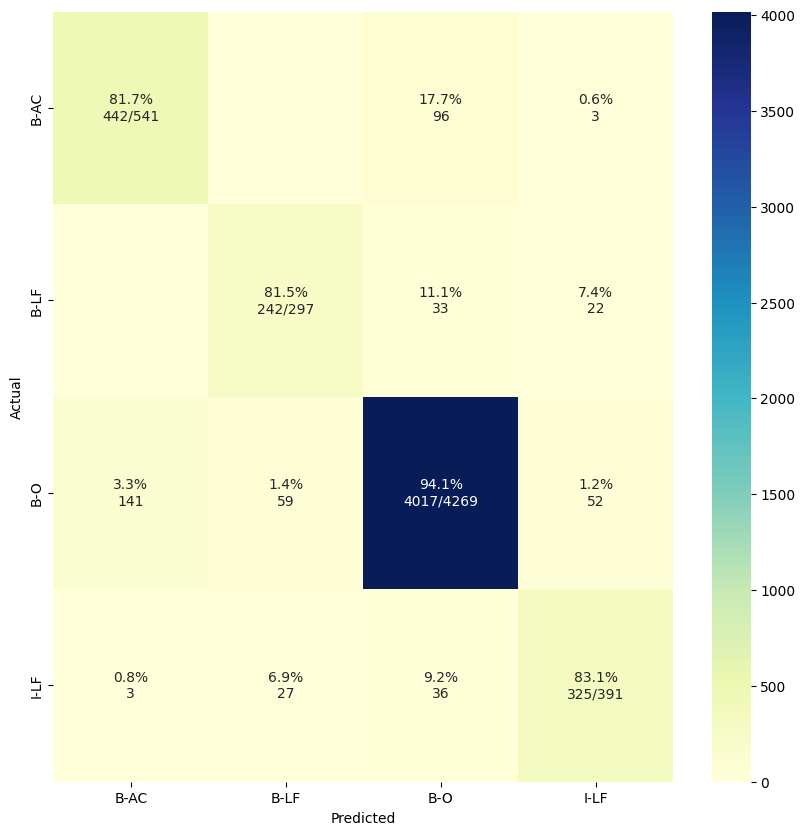

In [ ]:
plot_cm(true_labels, true_preds)

### Results of stop-word removal
With removal of stopwords, the time to train has not changed much, but the F1 score has gotten considerably worse with a score of 0.7.
The main reason for this is likely a combination of two things


1.   Stop words make up a considerable amount of many texts, so  being able to correctly 'tag' them is important. By removing them from our training data we have essentially stopped our model from 'learning' about stop words which is quite important given the task at hand.
2.   By removing stop words, we remove some of the context from the text. This will have an effect on our models ability to 'fine-tune' itself accurately to our training data



## Lemmatization
The final pre-processing technique I wish to apply is lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("rocks"))

rock


### Lemmatize the tokens


In [ ]:
def lemmatize_tokens(tokens):
  filtered_tokens = []
  for token in tokens:
    sublist = []
    for i in token:
      sublist.append(lemmatizer.lemmatize(i))

    filtered_tokens.append(sublist)
  return filtered_tokens



In [ ]:
training = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

training_tokens = training["tokens"]
training_labels = training["ner_tags"]
valid_tokens = valid["tokens"]
valid_labels = valid["ner_tags"]
test_tokens = test["tokens"]
test_labels = test["ner_tags"]




In [ ]:
lemmatized_train = lemmatize_tokens(training_tokens)
lemmatized_valid = lemmatize_tokens(valid_tokens)
lemmatized_test = lemmatize_tokens(test_tokens)
label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)


tokenized_datasets = tokenize_and_align_labels(lemmatized_train, tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(lemmatized_valid, tokenizer, val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(lemmatized_test, tokenizer, test_label_list)

tokenized_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)



In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model3 = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments (feel free to play arround with these values)
model_name = "bert-base-uncased"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args3 = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 7000,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer3 = Trainer(
    model3,
    args3,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer3.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1608, training_loss=0.17135502568524869, metrics={'train_runtime': 181.3184, 'train_samples_per_second': 35.474, 'train_steps_per_second': 8.868, 'total_flos': 277751226297792.0, 'train_loss': 0.17135502568524869, 'epoch': 6.0})

In [ ]:
results, true_labels, true_preds = calculate_results(trainer3, tokenized_test)
results

{'AC': {'precision': 0.7375886524822695,
  'recall': 0.7605118829981719,
  'f1': 0.7488748874887489,
  'number': 547},
 'LF': {'precision': 0.6965944272445821,
  'recall': 0.7450331125827815,
  'f1': 0.72,
  'number': 302},
 'O': {'precision': 0.9621226326645416,
  'recall': 0.9524781882309263,
  'f1': 0.9572761194029851,
  'number': 5387},
 'overall_precision': 0.9279742765273312,
 'overall_recall': 0.9255933290570879,
 'overall_f1': 0.926782273603083,
 'overall_accuracy': 0.9236560758921849}

<ipython-input-33-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


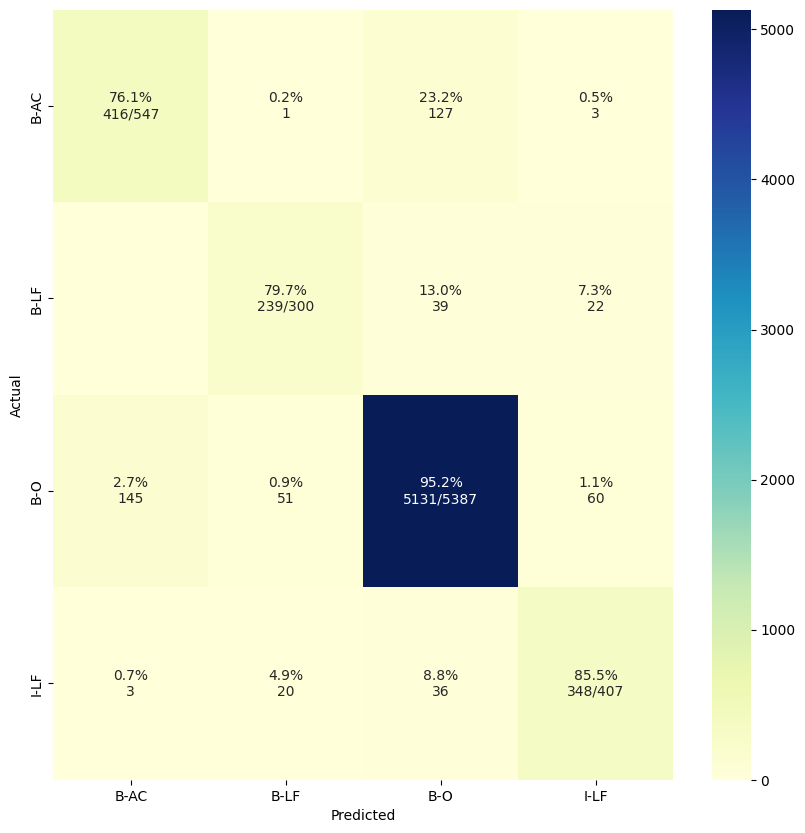

In [ ]:
plot_cm(true_labels, true_preds)

# Experiment 3: Hyperparameter tuning on ROBERTA model


In [4]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.2.1+cu121
torchtext Version:  0.17.1+cpu
Using GPU.


In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)




In [7]:
training = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]
training_tokens = training["tokens"]
training_labels = training["ner_tags"]
valid_tokens = valid["tokens"]
valid_labels = valid["ner_tags"]
test_tokens = test["tokens"]
test_labels = test["ner_tags"]

In [8]:
label_list, val_label_list, test_label_list = conv_label_indexes(training_labels, valid_labels, test_labels)
tokenized_datasets = tokenize_and_align_labels(training_tokens, rob_tokenizer, label_list)
tokenized_val_datasets = tokenize_and_align_labels(valid_tokens, rob_tokenizer,  val_label_list)
tokenized_test_datasets = tokenize_and_align_labels(test_tokens, rob_tokenizer, test_label_list)
tokenized_train = turn_dict_to_list_of_dict(tokenized_datasets)
tokenized_val = turn_dict_to_list_of_dict(tokenized_val_datasets)
tokenized_test = turn_dict_to_list_of_dict(tokenized_test_datasets)

In [9]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(rob_tokenizer)

In [10]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Training arguments (feel free to play arround with these values)
model_name = "roberta-base"
epochs = 6
batch_size = 4
learning_rate = 2e-5

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 100,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=35000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.217487,0.927902,0.923965,0.925929,0.920050
200,No log,0.183858,0.948625,0.937033,0.942794,0.937677
300,No log,0.210528,0.941636,0.941955,0.941795,0.935474
400,No log,0.184760,0.947710,0.941276,0.944482,0.939408
500,0.278500,0.184826,0.948214,0.941616,0.944903,0.939093
600,0.278500,0.177464,0.950710,0.942804,0.946741,0.941454
700,0.278500,0.203226,0.944492,0.944331,0.944411,0.937520
800,0.278500,0.195840,0.951684,0.949423,0.950552,0.945074
900,0.278500,0.193248,0.952779,0.948574,0.950672,0.945389
1000,0.136500,0.189577,0.950238,0.949593,0.949915,0.942556


TrainOutput(global_step=1608, training_loss=0.15983354956356446, metrics={'train_runtime': 192.1689, 'train_samples_per_second': 33.471, 'train_steps_per_second': 8.368, 'total_flos': 270589932571200.0, 'train_loss': 0.15983354956356446, 'epoch': 6.0})

In [ ]:
results, true_labels, true_preds = calculate_results(trainer, tokenized_test)
results

{'AC': {'precision': 0.8169717138103162,
  'recall': 0.8783542039355993,
  'f1': 0.8465517241379311,
  'number': 559},
 'LF': {'precision': 0.7329192546583851,
  'recall': 0.8137931034482758,
  'f1': 0.7712418300653594,
  'number': 290},
 'O': {'precision': 0.9757892698043773,
  'recall': 0.9552521805081532,
  'f1': 0.9654115167193639,
  'number': 5274},
 'overall_precision': 0.9472559973710154,
 'overall_recall': 0.9415319287930752,
 'overall_f1': 0.9443852895405029,
 'overall_accuracy': 0.9384024577572965}

<ipython-input-6-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


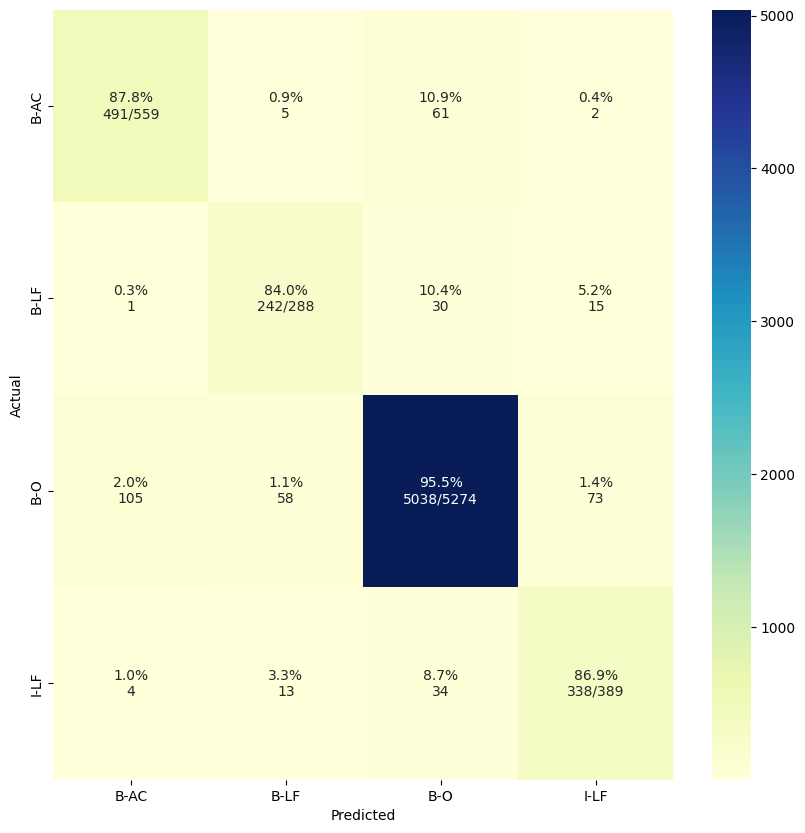

In [ ]:
plot_cm(true_labels, true_preds)


# Learning rate calculation loop

In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

# Load the RoBERTa tokenizer
rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

learning_rates = [2e-5, 2.1e-5, 2.3e-5, 2.7e-5, 2.9e-5, 1.9e-5, 1.7e-5, 1.5e-5, 1.3e-5, 1.1e-5]
best_learning = None
best_f1 = 0
trueLabels = []
truePreds = []

model_name = "roberta-base"
epochs = 6
batch_size = 4
for i in learning_rates:

  # Reload the RoBERTa model for token classification at the beginning of each iteration
  rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)
  print('Loading fresh model')
  args = TrainingArguments(
    f"checkpoints/{model_name}-finetuned-{int(i*1e5)}",
    evaluation_strategy='steps',
    eval_steps=150,
    save_total_limit=3,
    learning_rate=i,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=30000,
    metric_for_best_model='f1',
    load_best_model_at_end=True
  )

  trainer = Trainer(
    rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
  )
  trainer.train()
  result, labels, preds = calculate_results(trainer, tokenized_test)  # Assuming you have a function or method to evaluate on the test set
  f1 = result["overall_f1"]  # Adjust according to your actual results format
  print("F1 for learning rate ", i, "is: ", f1)
  trueLabels.append(labels)
  truePreds.append(preds)
  if f1 > best_f1:
    best_learning = i
    best_f1 = f1

print(f"Best Learning Rate: {best_learning}, Best F1 Score: {best_f1}")


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.201529,0.944684,0.930414,0.937495,0.932798
300,No log,0.169119,0.950890,0.943143,0.947001,0.942871
450,No log,0.177903,0.954209,0.940767,0.947440,0.940510
600,0.285400,0.184148,0.946915,0.950611,0.948759,0.942556
750,0.285400,0.175572,0.956217,0.948914,0.952551,0.946018
900,0.285400,0.206286,0.954584,0.945350,0.949945,0.942871
1050,0.140600,0.196183,0.956455,0.946877,0.951642,0.943815
1200,0.140600,0.236795,0.948941,0.943143,0.946033,0.938936
1350,0.140600,0.213984,0.952161,0.945859,0.949000,0.941454
1500,0.087900,0.216061,0.953830,0.946707,0.950256,0.942871


F1 for learning rate  2e-05 is:  0.9373565103312562


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.188261,0.937949,0.931263,0.934594,0.930910
300,No log,0.172109,0.949199,0.945010,0.947100,0.942398
450,No log,0.180387,0.948285,0.942974,0.945622,0.939093
600,0.282700,0.198366,0.942266,0.950102,0.946167,0.938779
750,0.282700,0.178165,0.953373,0.947386,0.950370,0.943658
900,0.282700,0.211080,0.956261,0.946198,0.951203,0.943815
1050,0.137800,0.193794,0.957898,0.949932,0.953899,0.946648
1200,0.137800,0.221641,0.949155,0.944162,0.946652,0.940195
1350,0.137800,0.222994,0.950965,0.944671,0.947808,0.940825
1500,0.082600,0.221356,0.952893,0.947556,0.950217,0.942713


F1 for learning rate  2.1e-05 is:  0.9437428243398392


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.187735,0.939846,0.930754,0.935278,0.930595
300,No log,0.182093,0.947396,0.935336,0.941327,0.935631
450,No log,0.178622,0.951261,0.940767,0.945985,0.940510
600,0.281500,0.188240,0.947235,0.950611,0.948920,0.941454
750,0.281500,0.190660,0.950691,0.945689,0.948183,0.941297
900,0.281500,0.207786,0.956634,0.947217,0.951902,0.945231
1050,0.136900,0.204088,0.955822,0.947386,0.951585,0.944130
1200,0.136900,0.210496,0.952584,0.947895,0.950234,0.943028
1350,0.136900,0.229898,0.952381,0.947047,0.949706,0.941297
1500,0.078300,0.225620,0.953623,0.949253,0.951433,0.943185


F1 for learning rate  2.3e-05 is:  0.9438976377952757


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.186850,0.941670,0.934318,0.937979,0.932169
300,No log,0.180494,0.950685,0.942295,0.946471,0.940825
450,No log,0.186542,0.948683,0.941276,0.944965,0.938936
600,0.280100,0.191508,0.950686,0.952138,0.951412,0.944759
750,0.280100,0.182913,0.952983,0.946029,0.949493,0.942556
900,0.280100,0.200676,0.956693,0.948574,0.952616,0.945546
1050,0.131900,0.200599,0.952552,0.943822,0.948167,0.941297
1200,0.131900,0.219182,0.951975,0.948744,0.950357,0.943028
1350,0.131900,0.236437,0.953186,0.946877,0.950021,0.942871
1500,0.071400,0.234679,0.953878,0.947726,0.950792,0.943972


F1 for learning rate  2.7e-05 is:  0.9454962707974757


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.189014,0.945863,0.937033,0.941427,0.936890
300,No log,0.186833,0.948524,0.938221,0.943345,0.937362
450,No log,0.197295,0.949528,0.938730,0.944098,0.936733
600,0.280700,0.181417,0.947039,0.949932,0.948483,0.940982
750,0.280700,0.178027,0.951228,0.946707,0.948962,0.942084
900,0.280700,0.216452,0.956208,0.945010,0.950576,0.943658
1050,0.134700,0.213287,0.953405,0.948065,0.950728,0.943185
1200,0.134700,0.213636,0.951336,0.948914,0.950123,0.942398
1350,0.134700,0.235620,0.952340,0.946198,0.949259,0.941297
1500,0.074100,0.231255,0.954832,0.950781,0.952802,0.944917


F1 for learning rate  2.9e-05 is:  0.9446403674239318


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.193803,0.937339,0.926680,0.931979,0.927762
300,No log,0.175837,0.950094,0.943483,0.946777,0.941454
450,No log,0.186269,0.945743,0.940767,0.943249,0.937520
600,0.283800,0.194000,0.942311,0.945350,0.943828,0.937520
750,0.283800,0.182406,0.951632,0.945010,0.948310,0.941454
900,0.283800,0.203853,0.957381,0.945519,0.951413,0.944287
1050,0.140100,0.201503,0.955792,0.946707,0.951228,0.944130
1200,0.140100,0.217923,0.952242,0.944162,0.948185,0.942084
1350,0.140100,0.225560,0.953915,0.945010,0.949442,0.942241
1500,0.086100,0.222897,0.954149,0.946538,0.950328,0.943028


F1 for learning rate  1.9e-05 is:  0.9454605101287624


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.201518,0.936609,0.925322,0.930931,0.926188
300,No log,0.183116,0.946062,0.937712,0.941868,0.936103
450,No log,0.192024,0.944956,0.941107,0.943027,0.936575
600,0.286500,0.188991,0.945713,0.949084,0.947395,0.941297
750,0.286500,0.177745,0.953325,0.946368,0.949834,0.943500
900,0.286500,0.195620,0.955567,0.945350,0.950431,0.943658
1050,0.143500,0.194085,0.954133,0.946198,0.950149,0.943500
1200,0.143500,0.209078,0.952821,0.946029,0.949412,0.943185
1350,0.143500,0.220375,0.952804,0.945689,0.949233,0.942084
1500,0.092900,0.218687,0.951884,0.943483,0.947665,0.940195


F1 for learning rate  1.7e-05 is:  0.9432228421398097


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.211503,0.933437,0.921079,0.927217,0.921782
300,No log,0.190845,0.941980,0.936864,0.939415,0.933585
450,No log,0.187017,0.943914,0.939749,0.941827,0.935159
600,0.290600,0.187846,0.944369,0.947895,0.946129,0.940038
750,0.290600,0.184295,0.949343,0.944671,0.947001,0.940353
900,0.290600,0.199037,0.955948,0.946538,0.951220,0.944602
1050,0.149000,0.195552,0.954304,0.946368,0.950320,0.943028
1200,0.149000,0.209347,0.952063,0.943822,0.947925,0.941454
1350,0.149000,0.217878,0.953667,0.946707,0.950175,0.942871
1500,0.099600,0.212301,0.953333,0.946538,0.949923,0.942084


F1 for learning rate  1.5e-05 is:  0.9424513586733436


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.224012,0.931967,0.918364,0.925115,0.918791
300,No log,0.198509,0.941588,0.935675,0.938623,0.932326
450,No log,0.181269,0.947198,0.940767,0.943971,0.938307
600,0.299700,0.195321,0.944360,0.947726,0.946040,0.939880
750,0.299700,0.185904,0.950256,0.943483,0.946857,0.940510
900,0.299700,0.197350,0.954202,0.944162,0.949155,0.942871
1050,0.155000,0.191312,0.954405,0.945010,0.949684,0.943028
1200,0.155000,0.210750,0.948556,0.941955,0.945244,0.939566
1350,0.155000,0.207884,0.953333,0.946538,0.949923,0.943500
1500,0.107700,0.203691,0.952365,0.946707,0.949528,0.942556


F1 for learning rate  1.3e-05 is:  0.942857142857143


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Loading fresh model


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.229682,0.928178,0.914630,0.921354,0.915644
300,No log,0.202164,0.940010,0.933469,0.936728,0.930595
450,No log,0.182301,0.945507,0.939409,0.942448,0.936575
600,0.309300,0.199834,0.940968,0.944162,0.942562,0.936575
750,0.309300,0.183200,0.948420,0.942464,0.945433,0.940510
900,0.309300,0.198810,0.953353,0.943483,0.948392,0.942556
1050,0.162000,0.190482,0.952625,0.945350,0.948974,0.942871
1200,0.162000,0.211775,0.946310,0.942295,0.944298,0.938149
1350,0.162000,0.205782,0.953088,0.948235,0.950655,0.943972
1500,0.115700,0.203401,0.951431,0.947556,0.949490,0.942713


F1 for learning rate  1.1e-05 is:  0.9425287356321839
Best Learning Rate: 2.7e-05, Best F1 Score: 0.9454962707974757


In [15]:
print(best_learning)
print(best_f1)

2.7e-05
0.9454962707974757


In [16]:
bestLearningIndex = learning_rates.index(best_learning)
bestLabels = trueLabels[bestLearningIndex]
bestPreds = truePreds[bestLearningIndex]



In [17]:
bestResults = metric.compute(predictions = bestPreds, references = bestLabels)
print(bestResults["overall_f1"])


0.9454962707974757


<ipython-input-3-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


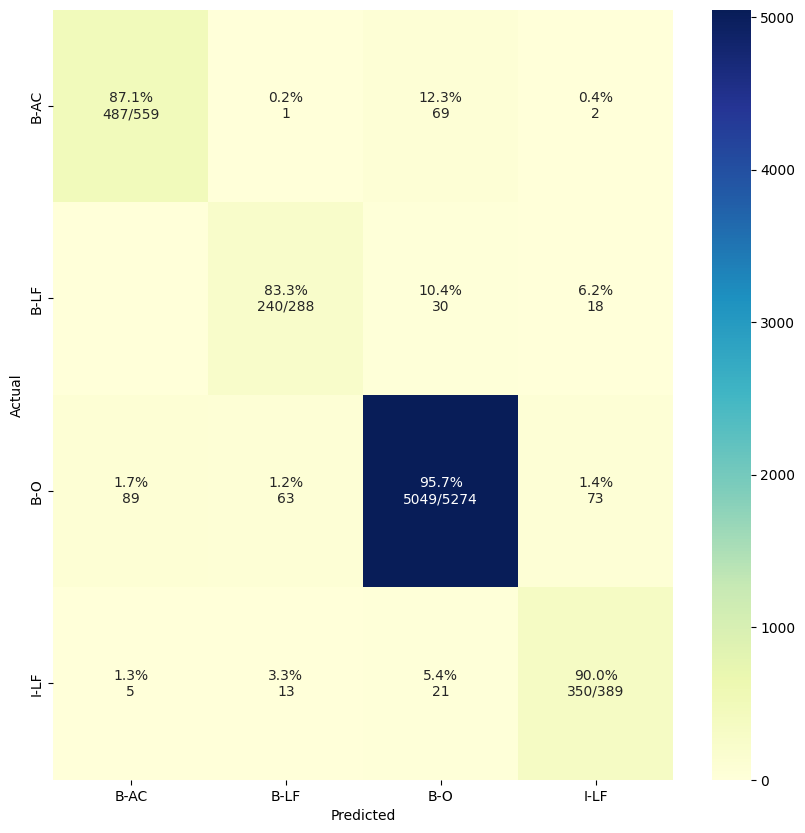

In [18]:
plot_cm(bestLabels, bestPreds)

## Results of learning rate testing
After testing different learning rates above, I have seen that F1 score does not vary hugely as learning rate changes with this algorithm. \


### Testing different batch sizes


In [19]:
from transformers import AutoTokenizer, AutoModelForTokenClassification,TrainingArguments, Trainer, EarlyStoppingCallback

f1scores = []
trueLabels = []
truePreds = []
batches = [2,4,8,16,20]
best_f1 = 0
best_batches = 0

rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

model_name = "bert-base-uncased"
epochs = 6
learning_rate = best_learning
trueLabels = []
truePreds = []

#iterate over first 3 batch values
for i in batches:
  rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)
  args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 150,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=i,
    per_device_eval_batch_size=i,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=30000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
  )

  trainer = Trainer(
    rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
  )
  trainer.train()
  result, labels, preds  = calculate_results(trainer, tokenized_test)
  f1 = result["overall_f1"]
  f1scores.append(f1)
  trueLabels.append(labels)
  truePreds.append(preds)
  if(f1 > best_f1):
    best_f1 = f1
    best_batches = i



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.253889,0.925669,0.927868,0.926767,0.922726
300,No log,0.181296,0.940326,0.938730,0.939528,0.934529
450,No log,0.186030,0.951190,0.936015,0.943541,0.938621
600,0.338400,0.189283,0.945049,0.942804,0.943925,0.938307
750,0.338400,0.196238,0.951127,0.931432,0.941176,0.934057
900,0.338400,0.190325,0.946706,0.931602,0.939093,0.933270
1050,0.211100,0.179232,0.953915,0.945010,0.949442,0.941769
1200,0.211100,0.253588,0.954796,0.939240,0.946954,0.939093
1350,0.211100,0.198353,0.934195,0.944501,0.939320,0.930910
1500,0.150400,0.202566,0.950672,0.948574,0.949622,0.943500


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.191044,0.939018,0.925153,0.932034,0.926188
300,No log,0.179568,0.948297,0.940088,0.944175,0.938149
450,No log,0.182757,0.944729,0.939919,0.942318,0.937205
600,0.279100,0.212642,0.938521,0.945689,0.942091,0.934215
750,0.279100,0.171750,0.958078,0.954175,0.956122,0.948536
900,0.279100,0.199773,0.957158,0.944162,0.950615,0.943343
1050,0.129500,0.200039,0.958091,0.950611,0.954336,0.947435
1200,0.129500,0.217238,0.955707,0.952138,0.953919,0.947907
1350,0.129500,0.214172,0.956121,0.950441,0.953273,0.946333
1500,0.073200,0.217408,0.955049,0.951969,0.953506,0.946648


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.200859,0.949485,0.937882,0.943648,0.938307
300,No log,0.194236,0.946043,0.937373,0.941688,0.935631
450,No log,0.193907,0.953820,0.942974,0.948366,0.943028
600,0.218800,0.220873,0.953891,0.944501,0.949173,0.943185
750,0.218800,0.226687,0.949702,0.945350,0.947521,0.940982


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.196247,0.944749,0.937373,0.941046,0.935002
300,No log,0.200259,0.951203,0.946198,0.948694,0.942398


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.193495,0.947035,0.937712,0.942350,0.936575
300,No log,0.207872,0.949727,0.945859,0.947789,0.940667


In [20]:

print(best_batches)

4


In [21]:
print(f1scores)
print(best_batches)
worstbatches = min(f1scores)
worstIndex = f1scores.index(worstbatches)
worstIndex
len(trueLabels)
worstLabels = trueLabels[worstIndex]
worstPreds = truePreds[worstIndex]

bestbatchesIndex = batches.index(best_batches)
bestLabels = trueLabels[bestbatchesIndex]
bestPreds = truePreds[bestbatchesIndex]



[0.941137891457616, 0.9444171175602558, 0.9432106858969106, 0.9388925294888596, 0.9431427166967067]
4


In [55]:
print(worstbatches)

0.9388925294888596


In [22]:
worstResults = metric.compute(predictions = worstPreds,references = worstLabels)
bestResults = metric.compute(predictions = bestPreds, references = bestLabels)
print(worstResults["overall_f1"])
print(bestResults["overall_f1"])

0.9388925294888596
0.9444171175602558


<ipython-input-3-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


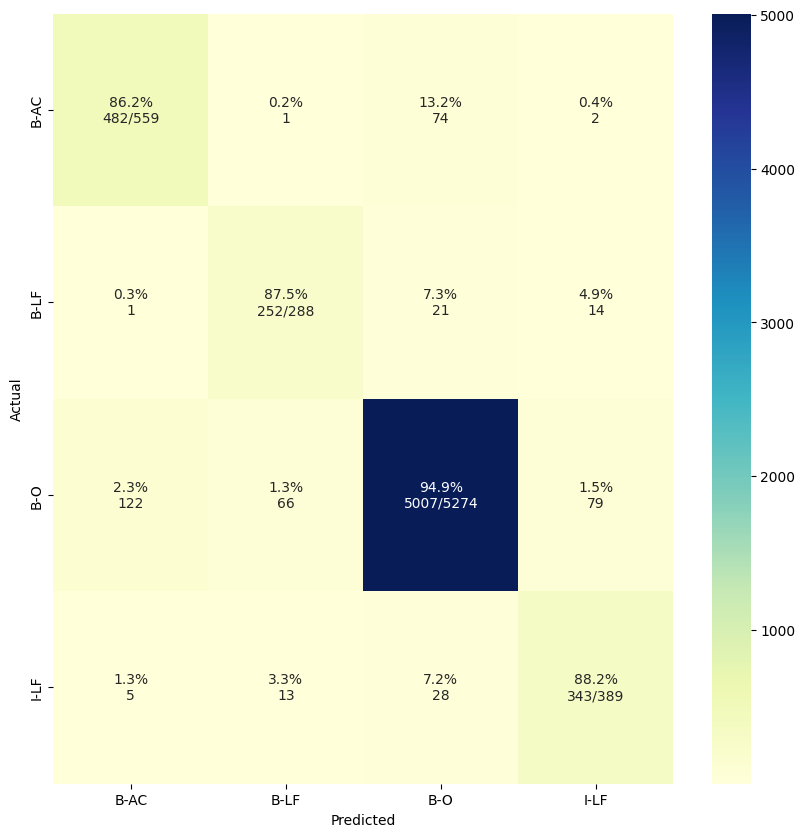

In [23]:
plot_cm(worstLabels, worstPreds)


<ipython-input-3-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


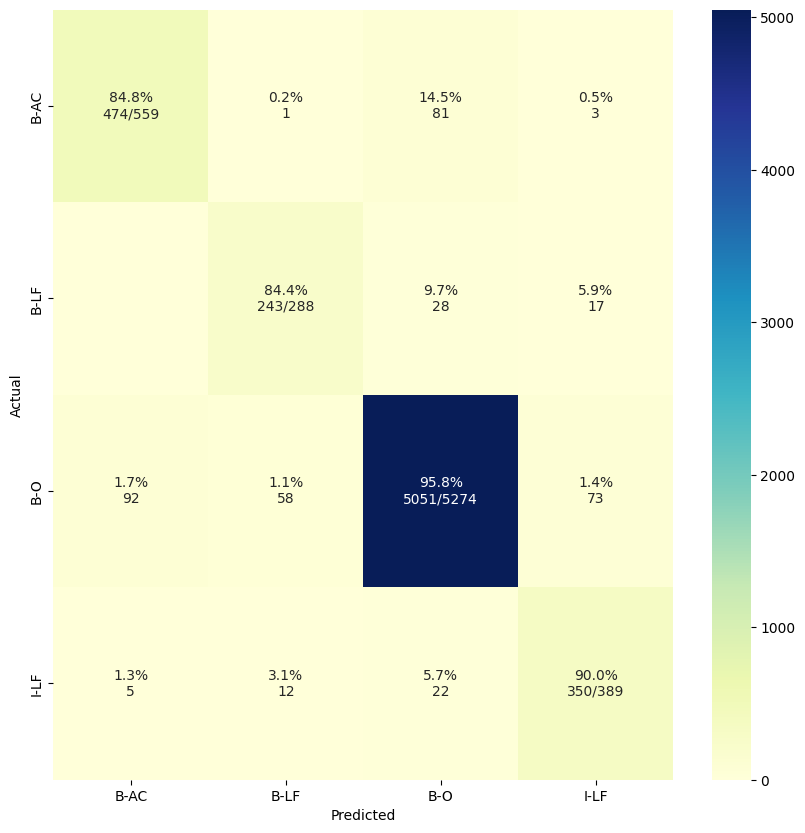

In [24]:
plot_cm(bestLabels, bestPreds)

### Experimenting with Epochs, batch size 4, learning rate 2.7e-5


In [46]:
from transformers import AutoTokenizer, AutoModelForTokenClassification,TrainingArguments, Trainer, EarlyStoppingCallback

different_epochs = [6, 12, 18, 24, 32]
f1scores = []
trueLabels = []
truePreds = []
best_f1 = 0
learning_rate = best_learning
batch_size = best_batches
rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)


model_name = "bert-base-uncased"

#iterate over first 3 batch values
for i in different_epochs:
  rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)
  args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 150,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=i,
    weight_decay=0.001,
    save_steps=30000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
  )

  trainer = Trainer(
    rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
  )
  trainer.train()
  result, labels, preds  = calculate_results(trainer, tokenized_test)
  f1 = result["overall_f1"]
  trueLabels.append(labels)
  truePreds.append(preds)
  if f1> best_f1:
    best_f1 = f1
    best_epochs = i
  f1scores.append(f1)




Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.203707,0.928195,0.925832,0.927012,0.920837
300,No log,0.183793,0.941870,0.934997,0.938421,0.933428
450,No log,0.188615,0.948032,0.944331,0.946178,0.939880
600,0.280100,0.188352,0.943358,0.949762,0.946549,0.939251
750,0.280100,0.191757,0.948805,0.949932,0.949368,0.941139
900,0.280100,0.210236,0.951721,0.943483,0.947584,0.941297
1050,0.133700,0.197453,0.952665,0.949593,0.951126,0.944287
1200,0.133700,0.217869,0.953469,0.949423,0.951441,0.944602
1350,0.133700,0.228919,0.953878,0.947726,0.950792,0.943972
1500,0.073000,0.225418,0.955081,0.949084,0.952073,0.945861


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.186744,0.941307,0.933639,0.937457,0.931382
300,No log,0.179541,0.947901,0.938730,0.943293,0.938149
450,No log,0.189922,0.949158,0.937882,0.943486,0.937992
600,0.282200,0.190045,0.946435,0.950611,0.948518,0.941926
750,0.282200,0.179248,0.947467,0.942804,0.945130,0.938464
900,0.282200,0.212062,0.954865,0.944331,0.949569,0.943815
1050,0.134800,0.225546,0.947990,0.940428,0.944194,0.937834
1200,0.134800,0.245023,0.944844,0.936185,0.940494,0.933585
1350,0.134800,0.276167,0.949656,0.938052,0.943818,0.937048
1500,0.074000,0.266845,0.945312,0.944671,0.944992,0.936733


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.200479,0.934690,0.935166,0.934928,0.930123
300,No log,0.180942,0.948494,0.940767,0.944615,0.939093
450,No log,0.192549,0.951986,0.935506,0.943674,0.936261
600,0.299000,0.184813,0.945008,0.947895,0.946450,0.940353
750,0.299000,0.189219,0.947672,0.946707,0.947190,0.939723
900,0.299000,0.227784,0.947692,0.940937,0.944303,0.937205
1050,0.142400,0.248796,0.942473,0.928717,0.935545,0.927919
1200,0.142400,0.259043,0.950806,0.941446,0.946103,0.938936
1350,0.142400,0.224886,0.955453,0.950102,0.952770,0.945703
1500,0.085500,0.244754,0.955810,0.950781,0.953289,0.945703


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.185872,0.941357,0.934487,0.937910,0.932169
300,No log,0.167445,0.950419,0.943483,0.946938,0.943658
450,No log,0.191150,0.952749,0.941107,0.946892,0.940982
600,0.281000,0.197188,0.944613,0.952308,0.948445,0.941139
750,0.281000,0.160098,0.954360,0.951120,0.952737,0.946805
900,0.281000,0.215454,0.946373,0.934487,0.940393,0.934057
1050,0.140000,0.213346,0.953532,0.943822,0.948652,0.941769
1200,0.140000,0.228403,0.955334,0.943822,0.949543,0.942871
1350,0.140000,0.248867,0.959285,0.947726,0.953471,0.946018
1500,0.078600,0.267899,0.948959,0.943483,0.946213,0.936575


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.203253,0.925820,0.929905,0.927858,0.923513
300,No log,0.185420,0.949545,0.939070,0.944279,0.938621
450,No log,0.191183,0.949991,0.934997,0.942434,0.935788
600,0.283700,0.193916,0.940027,0.947047,0.943524,0.936575
750,0.283700,0.169848,0.957553,0.945689,0.951584,0.945074
900,0.283700,0.240353,0.951702,0.939749,0.945687,0.938621
1050,0.144100,0.237916,0.946970,0.933469,0.940171,0.935002
1200,0.144100,0.252671,0.951646,0.941955,0.946776,0.939880
1350,0.144100,0.236253,0.955237,0.948914,0.952065,0.945546
1500,0.080500,0.236100,0.955787,0.950272,0.953021,0.946333


In [47]:
print(f1scores)
print(best_epochs)

worstEpochs = min(f1scores)
worstIndex = f1scores.index(worstEpochs)
worstLabels = trueLabels[worstIndex]
worstPreds = truePreds[worstIndex]

bestEpochs  = max(f1scores)
bestIndex = f1scores.index(bestEpochs)
print(bestIndex)
bestLabels = trueLabels[bestIndex]
bestPreds = truePreds[bestIndex]


[0.9437704918032788, 0.9446403674239318, 0.945436670489923, 0.9460744140304866, 0.9462630240380671]
32
4


In [58]:
worstResults = metric.compute(predictions = worstPreds,references = worstLabels)
bestResults = metric.compute(predictions = bestPreds, references = bestLabels)
print(worstResults["overall_f1"])
print(bestResults["overall_f1"])

0.9437704918032788
0.9462630240380671


<ipython-input-3-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


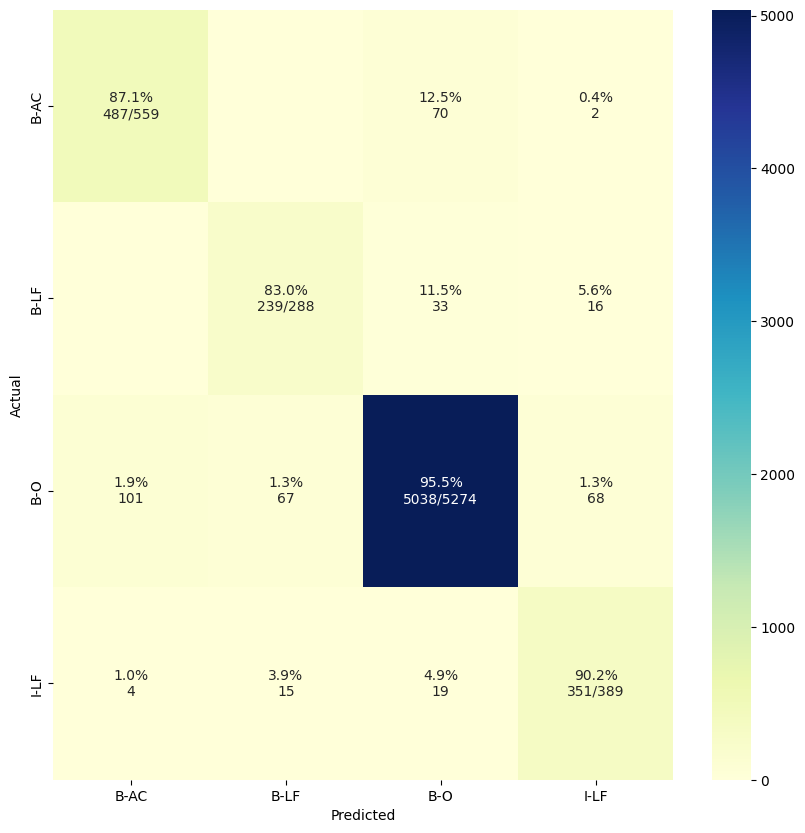

In [49]:
plot_cm(worstLabels, worstPreds)


<ipython-input-3-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


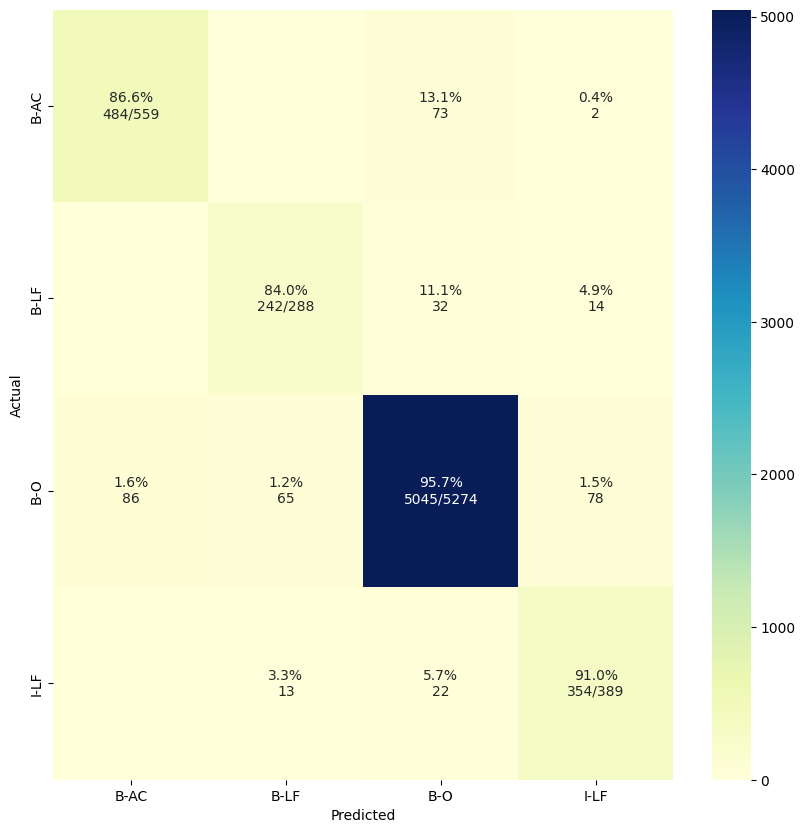

In [50]:
plot_cm(bestLabels, bestPreds)

10 epochs \
4 batch size
learning rate = 2.7e-05

In [51]:
print(best_learning)
print(best_batches)
print(best_epochs)

2.7e-05
4
32


In [52]:
from transformers import AutoTokenizer, AutoModelForTokenClassification,TrainingArguments, Trainer, EarlyStoppingCallback

rob_tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

rob_model = AutoModelForTokenClassification.from_pretrained("roberta-base", num_labels=4)

model_name = "bert-base-uncased"
learning_rate = 2.7e-05
batch_size = 4
epochs = 10
#iterate over first 3 batch values

args = TrainingArguments(
    f"BERT-finetuned-NER",
    # evaluation_strategy = "epoch", ## Instead of focusing on loss and accuracy, we will focus on the F1 score
    evaluation_strategy ='steps',
    eval_steps = 150,
    save_total_limit = 3,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.001,
    save_steps=30000,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    rob_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator = data_collator,
    tokenizer=rob_tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]
)
trainer.train()
result, labels, predictions  = calculate_results(trainer, tokenized_test)
f1 = result["overall_f1"]



Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
150,No log,0.192550,0.943548,0.933299,0.938396,0.932641
300,No log,0.178414,0.949132,0.937373,0.943216,0.938621
450,No log,0.186705,0.952545,0.940258,0.946361,0.939723
600,0.283700,0.196677,0.938236,0.946198,0.942200,0.936261
750,0.283700,0.189095,0.955792,0.946707,0.951228,0.944130
900,0.283700,0.234411,0.946159,0.936524,0.941317,0.934687
1050,0.137900,0.209950,0.953991,0.943143,0.948536,0.941454
1200,0.137900,0.228938,0.950239,0.946368,0.948299,0.942084
1350,0.137900,0.243599,0.957443,0.950781,0.954100,0.947907
1500,0.076800,0.258723,0.954623,0.949762,0.952186,0.945703


In [53]:
result

{'AC': {'precision': 0.8571428571428571,
  'recall': 0.8479427549194991,
  'f1': 0.8525179856115107,
  'number': 559},
 'LF': {'precision': 0.720125786163522,
  'recall': 0.7896551724137931,
  'f1': 0.7532894736842105,
  'number': 290},
 'O': {'precision': 0.9725790987535954,
  'recall': 0.9616989002654531,
  'f1': 0.9671083992754312,
  'number': 5274},
 'overall_precision': 0.9488991127177128,
 'overall_recall': 0.9431651151396374,
 'overall_f1': 0.9460234253419608,
 'overall_accuracy': 0.9408602150537635}

<ipython-input-3-2242e5f08155>:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


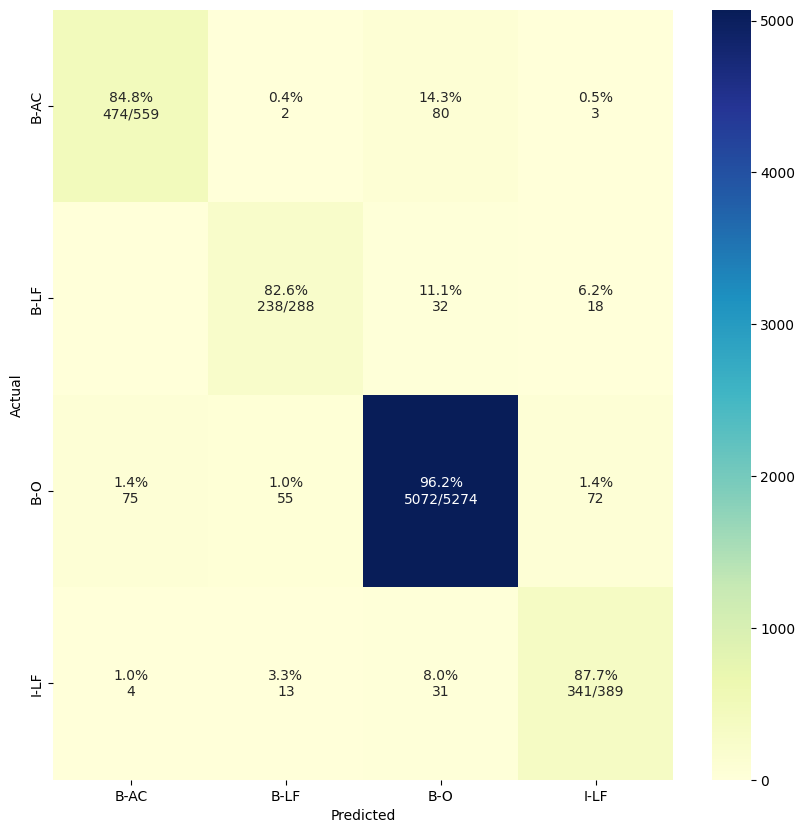

In [54]:
plot_cm(labels, predictions)

# Experiment 4: NLP Algorithms / Techniques
In this experiment I am exploring the performance of an RNN against BERT


## Installing dependencies for RNN

In [ ]:
%pip install torch==1.11.0+cu113 torchdata==0.3.0 torchtext==0.12.0 -f https://download.pytorch.org/whl/cu113/torch_stable.html
%pip install spacy tqdm
%pip install datasets
!python -m spacy download en_core_web_sm

In [4]:
from sklearn.metrics import f1_score

In [5]:
import torch
import torchtext

SEED = 1234
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.2.1+cu121
torchtext Version:  0.17.1+cpu
Using GPU.


In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [7]:
evaluation_label_list = ["B-O", "B-AC", "B-LF", "I-LF"]


In [8]:
train = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]


train_tokens = train["tokens"]
train_labels = train["ner_tags"]
valid_tokens = valid["tokens"]
valid_labels = valid["ner_tags"]
test_tokens = test["tokens"]
test_labels = test["ner_tags"]


In [9]:
from torchtext.data.utils import get_tokenizer

class SpacyTokenizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

    def forward(self, input):
        if isinstance(input, list):
            tokens = []
            for text in input:
                tokens.append(self.tokenizer(text))
            return tokens
        elif isinstance(input, str):
            return self.tokenizer(input)
        raise ValueError(f"Type {type(input)} is not supported.")

In [10]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab

from collections import OrderedDict
MAX_VOCAB_SIZE = 25_000

tokenizer = SpacyTokenizer()

def _process_texts_for_vocab(data):
	for line in data:
		yield tokenizer(" ".join(line))



text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(train_tokens), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("B-O", 1), ("B-AC", 2), ("B-LF", 3), ("I-LF", 4)]))

text_vocab.set_default_index(text_vocab["<unk>"])

In [11]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab

from collections import OrderedDict
MAX_VOCAB_SIZE = 25_000

tokenizer = SpacyTokenizer()

def _process_texts_for_vocab(data):
	for line in data:
		yield tokenizer(" ".join(line))



text_vocab = build_vocab_from_iterator(_process_texts_for_vocab(train_tokens), specials=('<unk>', '<pad>'), max_tokens=MAX_VOCAB_SIZE)
label_vocab = vocab(OrderedDict([("B-O", 1), ("B-AC", 2), ("B-LF", 3), ("I-LF", 4)]))

text_vocab.set_default_index(text_vocab["<unk>"])

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [12]:
import torch
from torchtext.transforms import ToTensor, VocabTransform, Truncate
import torchtext.transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch import nn

In [13]:
def transform_dataset(tokens, labels):
  flattened_tokens = [item for sublist in tokens for item in sublist]
  flattened_labels = [item for sublist in labels for item in sublist]
  return flattened_tokens, flattened_labels


In [14]:
train_tokens, train_labels = transform_dataset(train_tokens, train_labels)
valid_tokens, valid_labels = transform_dataset(valid_tokens, valid_labels)
test_tokens, test_labels = transform_dataset(test_tokens, test_labels)

len(train_tokens)

40000

In [15]:
class ToLengths(torch.nn.Module):
    def forward(self, input):
        if isinstance(input[0], list):
            lengths = []
            for text in input:
                lengths.append(len(text))
            return lengths
        elif isinstance(input, list):
            return len(input)
        elif isinstance(input, str):
          return len(input)
        raise ValueError(f"Type {type(input)} is not supported.")

lengths_transform = T.Sequential(
    SpacyTokenizer(),
    ToLengths(),
    T.ToTensor(),
)
import torchtext.transforms as T

text_transform = T.Sequential(
    #SpacyTokenizer(),  # Tokenize
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer
    T.ToTensor(),  # Convert to tensor

)



In [16]:
sample_label, sample_text = train_labels[:10], train_tokens[:10]

print(f"Text before any processing: {sample_text}")
print(f"Label before any processing: {sample_label}\n")

#Text processing pipeline

vocab_transform = T.VocabTransform(text_vocab)
sample_text = vocab_transform(sample_text)

print(f"Text after Vocab Transform: {sample_text}\n")

tensor_transform = T.ToTensor(padding_value=text_vocab["<pad>"])
sample_text = tensor_transform(sample_text)
print(f"Text after Tensor Transform: {sample_text}\n")
print(type(sample_text))
# Label Processing Pipeline
print(f"Label after label transform: {label_transform(sample_label)}\n")

# # Length Processing Pipeline
print(f"Text after length transform: {lengths_transform(train_tokens[:10])}")

Text before any processing: ['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(']
Label before any processing: ['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O']

Text after Vocab Transform: [254, 60, 8411, 5, 4886, 6323, 5689, 4680, 1621, 3]

Text after Tensor Transform: tensor([ 254,   60, 8411,    5, 4886, 6323, 5689, 4680, 1621,    3])

<class 'torch.Tensor'>
Label after label transform: tensor([0, 0, 0, 0, 2, 3, 3, 3, 3, 0])

Text after length transform: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [17]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

def collate_batch(batch):
    labels, texts = zip(*batch)
    lengths = torch.ones(BATCH_SIZE)
    texts = text_transform(list(texts))
    labels = label_transform(list(labels))
    labels = labels.long()
    texts = texts.unsqueeze(1)

    return labels.float().to(DEVICE), texts.to(DEVICE), lengths.cpu()

def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, drop_last = True)

train_data = list(zip(train_labels, train_tokens))
valid_data = list(zip(valid_labels, valid_tokens))
test_data = list(zip(test_labels, test_tokens))

train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [18]:
import torch

def categorical_accuracy(preds, y):

    softmax_preds = torch.softmax(preds, dim=1)

    top_pred = torch.argmax(softmax_preds, dim=1)

    correct = (top_pred == y).float()  # convert into float for division

    # Calculate accuracy
    acc = correct.sum() / len(correct)
    return acc


In [19]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for batch in tqdm(iterator, desc="\tTraining"):
        optimizer.zero_grad()
        labels, texts, lengths = batch
        labels = labels.to(DEVICE).long()

        predictions = model(texts, lengths)
        predictions = predictions.to(DEVICE).float()

        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print('finished batches')
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


from tqdm import tqdm


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch
            labels = labels.to(DEVICE).long()
            predictions = model(texts, lengths).squeeze(1)
            predictions = predictions.to(DEVICE).float()
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            batch_predictions = predictions.argmax(dim=1)

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [268]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)
        embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        output, hidden = self.rnn(embedded)

        return self.fc(hidden.squeeze(0))

In [269]:
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 4

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [270]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = 2e-5)
criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [20]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [272]:
N_EPOCHS = 5

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

Using GPU for training.
Epoch: 01


	Training: 100%|██████████| 625/625 [00:02<00:00, 209.06it/s]


finished batches
	Train Loss: 1.150 | Train Acc: 59.24%


	Evaluation: 100%|██████████| 78/78 [00:00<00:00, 399.17it/s]


	 Val. Loss: 1.016 |  Val. Acc: 64.62%
Epoch: 02


	Training: 100%|██████████| 625/625 [00:06<00:00, 98.39it/s] 


finished batches
	Train Loss: 0.871 | Train Acc: 71.97%


	Evaluation: 100%|██████████| 78/78 [00:00<00:00, 138.51it/s]


	 Val. Loss: 0.828 |  Val. Acc: 70.27%
Epoch: 03


	Training: 100%|██████████| 625/625 [00:08<00:00, 72.02it/s]


finished batches
	Train Loss: 0.744 | Train Acc: 76.73%


	Evaluation: 100%|██████████| 78/78 [00:00<00:00, 173.50it/s]


	 Val. Loss: 0.710 |  Val. Acc: 73.82%
Epoch: 04


	Training: 100%|██████████| 625/625 [00:03<00:00, 157.85it/s]


finished batches
	Train Loss: 0.668 | Train Acc: 80.45%


	Evaluation: 100%|██████████| 78/78 [00:00<00:00, 514.65it/s]


	 Val. Loss: 0.623 |  Val. Acc: 75.62%
Epoch: 05


	Training: 100%|██████████| 625/625 [00:03<00:00, 169.33it/s]


finished batches
	Train Loss: 0.623 | Train Acc: 81.81%


	Evaluation: 100%|██████████| 78/78 [00:00<00:00, 303.47it/s]

	 Val. Loss: 0.573 |  Val. Acc: 85.08%


In [21]:

import numpy as np

metric = load_metric("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [evaluation_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [evaluation_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


# Prepare the test data for evaluation in the same format as the training data
def calculate_results(trainer, data):

	# Remove the predictions for the [CLS] and [SEP] tokens
	true_predictions = [
			[evaluation_label_list[p] for (p, l) in zip(prediction, label) if l != -100]
			for prediction, label in zip(predictions, labels)
	]
	true_labels = [
			[evaluation_label_list[l] for (p, l) in zip(prediction, label) if l != -100]
			for prediction, label in zip(predictions, labels)
	]

	# Compute multiple metrics on the test restuls
	results = metric.compute(predictions=true_predictions, references=true_labels)
	return results, true_labels, true_predictions

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [22]:

import torch
import numpy as np
from tqdm import tqdm
def predict(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    all_predictions = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="\tEvaluation"):
            labels, texts, lengths = batch
            labels = labels.to(DEVICE).long()
            all_labels.extend(labels.tolist())
            predictions = model(texts, lengths)
            softmax_preds = torch.softmax(predictions, dim=1)
            predictions = softmax_preds.argmax(dim=1).tolist()
            all_predictions.extend(predictions)


    # all_predictions = np.concatenate(all_predictions, axis=0)
    # all_labels = np.concatenate(all_labels, axis=0)

    return all_labels, all_predictions

In [274]:
model.load_state_dict(torch.load('tut1-model.pt'))
mylabs, mypreds = predict(model, test_dataloader, criterion)

	Evaluation: 100%|██████████| 78/78 [00:00<00:00, 359.38it/s]


In [275]:
print(mylabs[:20])
print(mypreds[:20])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [276]:
true_preds = [evaluation_label_list[p] for (p, l) in zip(mypreds, mylabs)]
true_labels = [evaluation_label_list[l] for (p,l) in zip(mypreds,mylabs)]



In [277]:
len(true_preds), len(true_labels)
print(true_preds[:20])
print(true_labels[:20])
# results = metric.compute(predictions = true_preds, references = true_labels)

['B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O']
['B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O']


In [278]:
results = metric.compute(predictions = [true_preds], references = [true_labels])

In [279]:
results

{'AC': {'precision': 0.2857142857142857,
  'recall': 0.007407407407407408,
  'f1': 0.01444043321299639,
  'number': 270},
 'LF': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 411},
 'O': {'precision': 0.8589511754068716,
  'recall': 0.9976662777129521,
  'f1': 0.9231267544806737,
  'number': 4285},
 'overall_precision': 0.8567708333333334,
 'overall_recall': 0.8612565445026178,
 'overall_f1': 0.8590078328981723,
 'overall_accuracy': 0.8569711538461539}

In [23]:

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_cm(y_true, y_pred, figsize=(10,10)):
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
      for j in range(ncols):
          c = cm[i, j]
          p = cm_perc[i, j]
          if i == j:
              s = cm_sum[i]
              annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
          elif c == 0:
              annot[i, j] = ''
          else:
              annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  plt.savefig('output.png')
  sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax).figure.savefig('file.png')

<ipython-input-280-06ba3fd0ed4f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


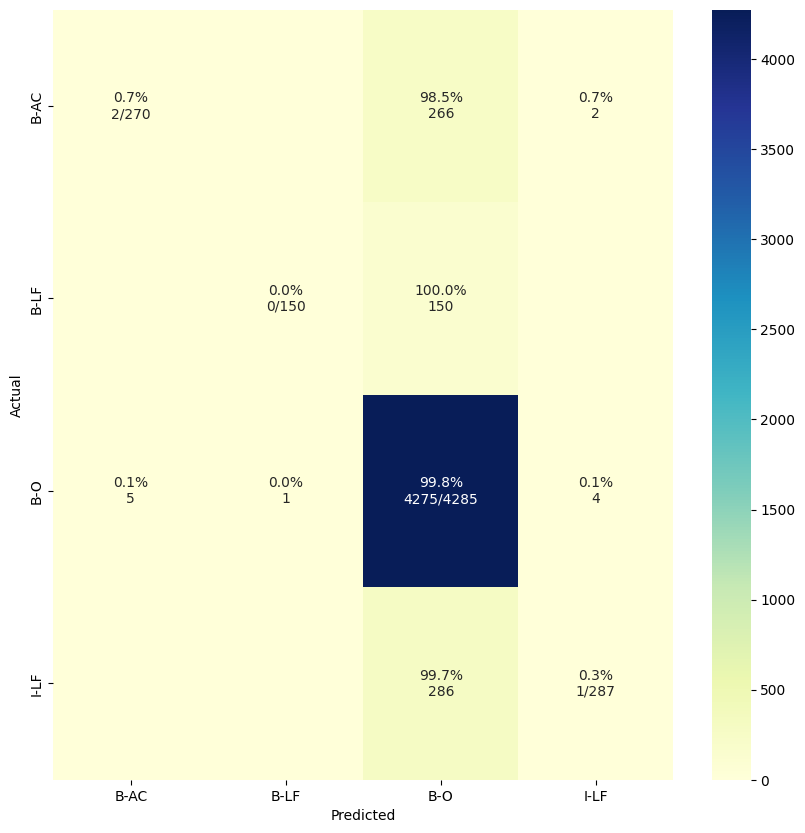

In [281]:
plot_cm(true_labels, true_preds)

### Experimenting with more epochs

In [155]:
#re-train model with more epochs

In [282]:
del model
del optimizer
torch.cuda.empty_cache()


In [283]:
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 4

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)


import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = 2e-5)
criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


model.load_state_dict(torch.load('tut1-model.pt'))
mylabs, mypreds = predict(model, test_dataloader, criterion)

true_preds = [evaluation_label_list[p] for (p, l) in zip(mypreds, mylabs)]
true_labels = [evaluation_label_list[l] for (p,l) in zip(mypreds,mylabs)]

results = metric.compute(predictions = [true_preds], references = [true_labels])
results
plot_cm(true_labels, true_preds)

## Trying out LSTM instead of RNN

In [286]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, bidirectional=True, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Use bidirectional and add dropout
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, texts, lengths):
        embedded = self.embedding(texts)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.rnn(packed_embedded)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        return self.fc(hidden)

In [287]:
del model
del optimizer
torch.cuda.empty_cache()



In [288]:
INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 4

model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

optimizer = optim.Adam(model.parameters(), lr = 2e-5)
criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

mylabs, mypreds = predict(model, test_dataloader, criterion)
true_preds = [evaluation_label_list[p] for (p, l) in zip(mypreds, mylabs)]
true_labels = [evaluation_label_list[l] for (p,l) in zip(mypreds,mylabs)]

results = metric.compute(predictions = [true_preds], references = [true_labels])
results


<ipython-input-280-06ba3fd0ed4f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


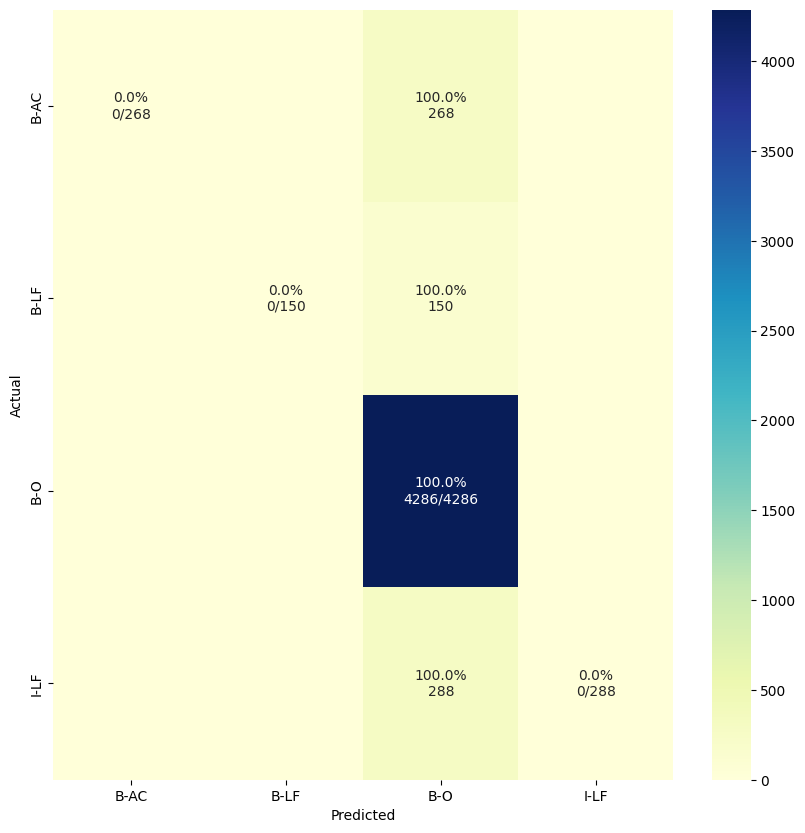

In [291]:
plot_cm(true_labels, true_preds)

## Conclusion about RNN / LSTM at this point
All three iterations I have tried so far have been completely ineffective at predicting anything other than B-O tags.
## Trying smaller batches
By default I've been using batches of 64, which given the size of the dataset might not be the best idea, I will now try a smaller value of 16
For this I need to re-make the data



In [292]:
BATCH_SIZE = 16
train_data = list(zip(train_labels, train_tokens))
valid_data = list(zip(valid_labels, valid_tokens))
test_data = list(zip(test_labels, test_tokens))

train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)



In [296]:
del model
del optimizer
torch.cuda.empty_cache()

INPUT_DIM = len(text_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 4

model = LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

optimizer = optim.Adam(model.parameters(), lr = 2e-5)
criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


model.load_state_dict(torch.load('tut1-model.pt'))

mylabs, mypreds = predict(model, test_dataloader, criterion)
true_preds = [evaluation_label_list[p] for (p, l) in zip(mypreds, mylabs)]
true_labels = [evaluation_label_list[l] for (p,l) in zip(mypreds,mylabs)]

results = metric.compute(predictions = [true_preds], references = [true_labels])
results


<ipython-input-280-06ba3fd0ed4f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


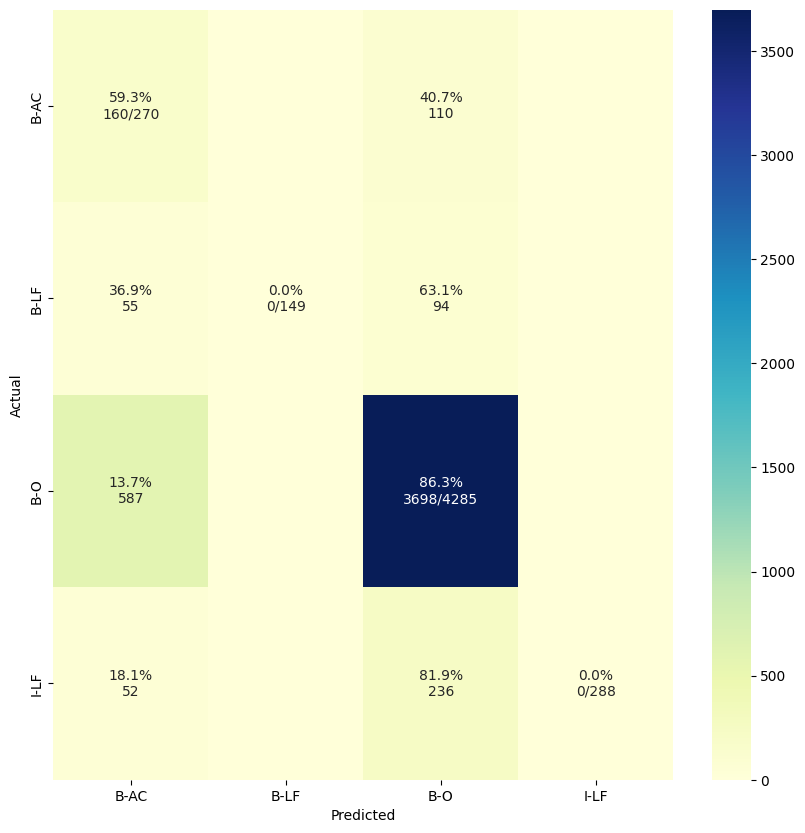

In [295]:
plot_cm(true_labels, true_preds)

## Trying LSTM with word embeddings

In [87]:
from torchtext import vocab

MAX_VOCAB_SIZE = 25_000

glove_vectors = vocab.GloVe(
    name="6B",
    dim=100,
    max_vectors=MAX_VOCAB_SIZE
)


In [88]:
from torchtext.vocab import vocab

text_vocab = vocab(glove_vectors.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])

label_vocab = vocab(OrderedDict([("B-O", 1), ("B-AC", 2), ("B-LF", 3), ("I-LF", 4)]))


pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, glove_vectors.dim).normal_(),  # unk token vector
    torch.zeros(1, glove_vectors.dim),  # padding token vector
    pretrained_embeddings
])

In [ ]:
print("Vocab size: ", len(text_vocab))
print("Pretrained vectors shape: ", pretrained_embeddings.shape)
print("<unk> vector: ", pretrained_embeddings[text_vocab["<unk>"]])
print("<pad> vector: ", pretrained_embeddings[text_vocab["<pad>"]])


In [89]:
print(label_vocab.get_stoi())
print(label_vocab.get_itos())

text_transform = T.Sequential(
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer
    T.ToTensor(),  # Convert to tensor
)

{'I-LF': 3, 'B-LF': 2, 'B-AC': 1, 'B-O': 0}
['B-O', 'B-AC', 'B-LF', 'I-LF']


In [90]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

def collate_batch(batch):
    labels, texts = zip(*batch)
    lengths = torch.ones(BATCH_SIZE)
    texts = text_transform(list(texts))
    labels = label_transform(list(labels))
    labels = labels.long()
    texts = texts.unsqueeze(1)

    return labels.float().to(DEVICE), texts.to(DEVICE), lengths.cpu()

def _get_dataloader(data):
    return DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch, drop_last = True)

train_data = list(zip(train_labels, train_tokens))
valid_data = list(zip(valid_labels, valid_tokens))
test_data = list(zip(test_labels, test_tokens))

train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [91]:
import torch.nn as nn
class RNN_Embeddings(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.LSTM(pretrained_embeddings.shape[1],
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))                   # VV note that lengths need to be on the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        if self.num_directions == 2:  # if bidirectional
            # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            # and apply dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

In [92]:
HIDDEN_DIM = 256
OUTPUT_DIM = 4
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = text_vocab["<pad>"]

model = RNN_Embeddings(
    pretrained_embeddings,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT,
    PAD_IDX
)

In [93]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,312,196 trainable parameters


In [68]:
del model
del optimizer
torch.cuda.empty_cache()



In [94]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr = 2e-5)


In [ ]:
N_EPOCHS = 6
best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


model.load_state_dict(torch.load('tut1-model.pt'))

mylabs, mypreds = predict(model, test_dataloader, criterion)
true_preds = [evaluation_label_list[p] for (p, l) in zip(mypreds, mylabs)]
true_labels = [evaluation_label_list[l] for (p,l) in zip(mypreds,mylabs)]

results = metric.compute(predictions = [true_preds], references = [true_labels])
results


<ipython-input-23-06ba3fd0ed4f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


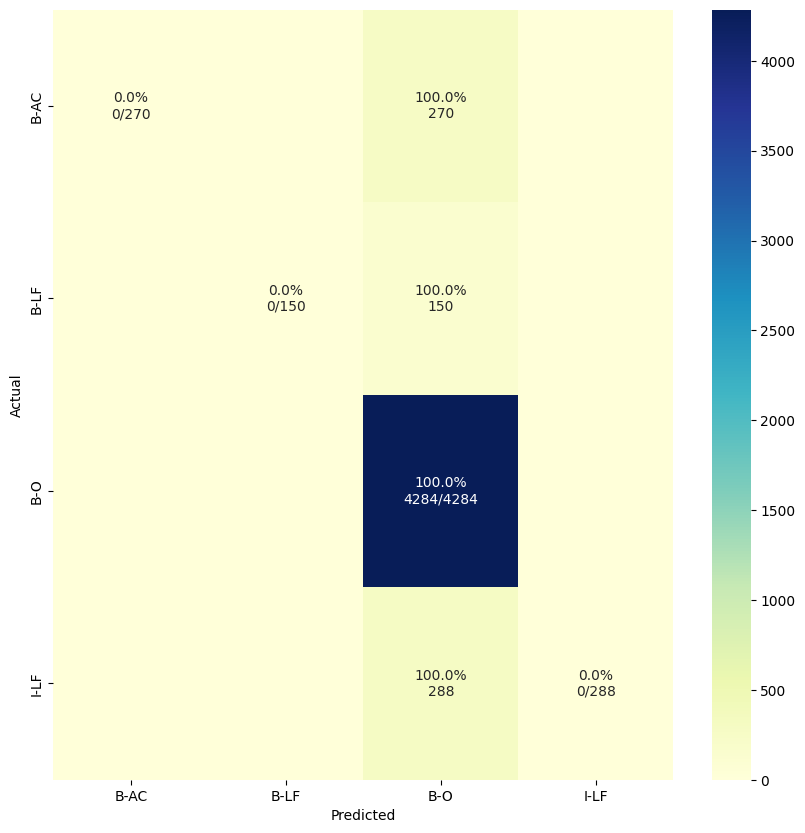

In [96]:
plot_cm(true_labels, true_preds)

In [97]:
## Trying with FastToken word embeddings
from torchtext import vocab
MAX_VOCAB_SIZE = 25_000

fasttext = vocab.FastText(language='en', max_vectors=MAX_VOCAB_SIZE)

In [99]:
text_vocab = vocab.vocab(fasttext.stoi, min_freq=0, specials=("<unk>", "<pad>"), special_first=True)
text_vocab.set_default_index(text_vocab["<unk>"])
label_vocab = vocab.vocab(OrderedDict([("B-O", 1), ("B-AC", 1), ("B-LF", 1), ("I-LF", 1)]))

pretrained_embeddings = fasttext.vectors
pretrained_embeddings = torch.cat([
    torch.empty(1, fasttext.dim).normal_(),  # unk token vector
    torch.zeros(1, fasttext.dim),  # padding token vector
    pretrained_embeddings
])


text_vocab.set_default_index(text_vocab["<unk>"])
print(label_vocab.get_stoi())
print(label_vocab.get_itos())

text_transform = T.Sequential(
    T.VocabTransform(text_vocab),  # Conver to vocab IDs
    T.ToTensor(padding_value=text_vocab["<pad>"]),  # Convert to tensor and pad
)

label_transform = T.Sequential(
    T.LabelToIndex(label_vocab.get_itos()),  # Convert to integer
    T.ToTensor(),  # Convert to tensor
)


{'I-LF': 3, 'B-LF': 2, 'B-AC': 1, 'B-O': 0}
['B-O', 'B-AC', 'B-LF', 'I-LF']


In [100]:

train_data = list(zip(train_labels, train_tokens))
valid_data = list(zip(valid_labels, valid_tokens))
test_data = list(zip(test_labels, test_tokens))

train_dataloader = _get_dataloader(train_data)
valid_dataloader = _get_dataloader(valid_data)
test_dataloader = _get_dataloader(test_data)

In [101]:
import torch.nn as nn
class RNN_Embeddings(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=pad_idx)
        self.rnn = nn.LSTM(pretrained_embeddings.shape[1],
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))                   # VV note that lengths need to be on the CPU
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        if self.num_directions == 2:  # if bidirectional
            # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
            # and apply dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

In [102]:
HIDDEN_DIM = 256
OUTPUT_DIM = 4
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = text_vocab["<pad>"]

model = RNN_Embeddings(
    pretrained_embeddings,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT,
    PAD_IDX
)

In [103]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 2e-5)


In [ ]:
N_EPOCHS = 6
best_valid_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()

    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')


mylabs, mypreds = predict(model, test_dataloader, criterion)
true_preds = [evaluation_label_list[p] for (p, l) in zip(mypreds, mylabs)]
true_labels = [evaluation_label_list[l] for (p,l) in zip(mypreds,mylabs)]

results = metric.compute(predictions = [true_preds], references = [true_labels])
results


<ipython-input-23-06ba3fd0ed4f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


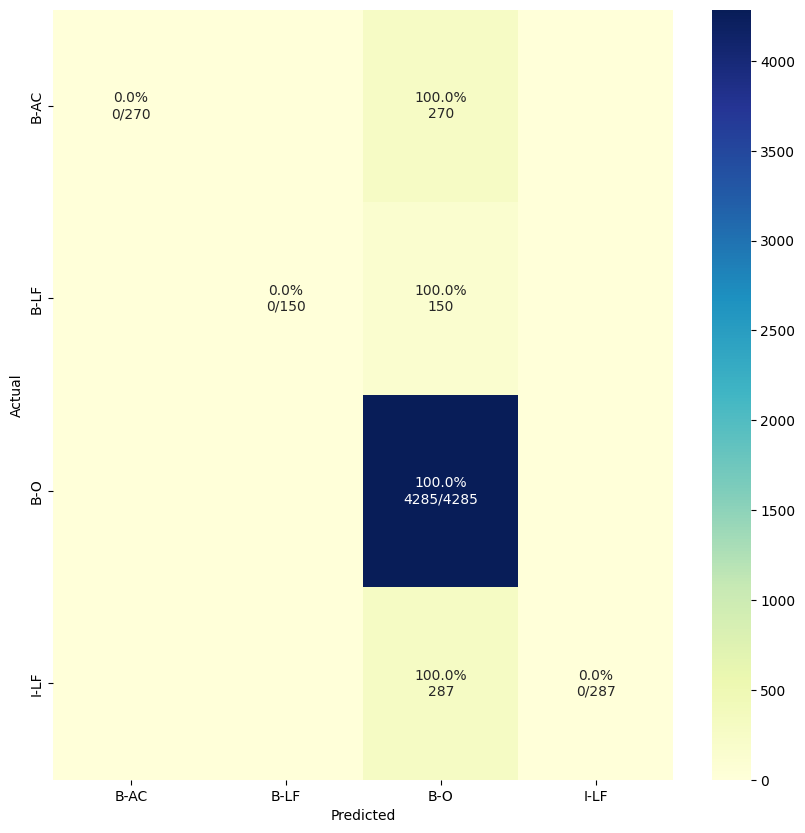

In [105]:
plot_cm(true_labels, true_preds)